# PROYECTO PREDICCIÓN DE PRECIOS DE AUTOMOVILES A TRAVES DE MODELOS DE REGRESIÓN LINEAL
Predecir el valor de un vehículo ([MSRP](https://ecommerce-platforms.com/es/glossary/manufacturers-suggested-retail-price-msrp)) de acuerdo a sus atributos

In [ ]:
#Librerías utilizadas
import numpy as np
import pandas as pd
import seaborn as sns 
import statistics as stat
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
#Definimos las siguientes funciones:
#Función para anotaciones de estadísticos boxplot
def anotaciones(tamano,valor,tipoCoordenada,estadistico,direccionFlecha,ejeFlecha=1,ejeTexto=1):
    xy = (ejeFlecha + tamano/2 , valor)
    xytext = (ejeTexto + tamano ,valor)
    xycoords=tipoCoordenada
    arrowprops = dict(arrowstyle=direccionFlecha,connectionstyle="angle3,angleA=10,angleB=90") #Se modifica angulo de flecha, para dar ligera curva
    return plt.annotate(s = f"{valor} \n{estadistico}", xy = xy, 
             xytext = xytext, xycoords = xycoords, arrowprops=arrowprops)

#Función para obtener límite de outliers según rango intercuartílico
def outlierLimites(columna):
    q1 = columna.quantile(0.25) 
    q3 = columna.quantile(0.75)
    iqr = q3-q1
    return [q1-1.5*iqr,q3+1.5*iqr] #Se obtiene límite inferior y superior

####DESCRIPCIÓN DEL CONJUNTO DE DATOS

Para el análisis utilizaremos el set de datos "Car Features and MSRP" que contiene variables como fabricante, modelo, año y tipo de motor para predecir el precio de un automovil.

In [ ]:
#Archivo en drive del modulo
#Fuente: https://www.kaggle.com/CooperUnion/cardataset?select=data.csv
link= 'https://drive.google.com/uc?export=download&id=1dV8qqFnmnSAlilojHC49Lm4zPJ2cWI2K'  #Espejo de data en nuestro drive

In [ ]:
#Cargar set de datos
#automoviles = pd.read_csv('dataProyecto.csv')
automoviles = pd.read_csv(link)
automoviles.head(5)

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


In [ ]:
#Obtener dimensiones del set de datos
print('El nº de observaciones del set de datos es {}, incluye {} variables'.format(automoviles.shape[0],automoviles.shape[1]))

El nº de observaciones del set de datos es 11914, incluye 16 variables


In [ ]:
#Estadísticos de los datos
automovilesDetalle = automoviles.describe() #Como utilizaremos una regresión logística solo visualizaremos las variables cuantitativas
automovilesDetalle

,Year,Engine HP,Engine Cylinders,Number of Doors,highway MPG,city mpg,Popularity,MSRP
count,11914.000000,11845.00000,11884.000000,11908.000000,11914.000000,11914.000000,11914.000000,1.191400e+04
mean,2010.384338,249.38607,5.628829,3.436093,26.637485,19.733255,1554.911197,4.059474e+04
std,7.579740,109.19187,1.780559,0.881315,8.863001,8.987798,1441.855347,6.010910e+04
min,1990.000000,55.00000,0.000000,2.000000,12.000000,7.000000,2.000000,2.000000e+03
25%,2007.000000,170.00000,4.000000,2.000000,22.000000,16.000000,549.000000,2.100000e+04
50%,2015.000000,227.00000,6.000000,4.000000,26.000000,18.000000,1385.000000,2.999500e+04
75%,2016.000000,300.00000,6.000000,4.000000,30.000000,22.000000,2009.000000,4.223125e+04
max,2017.000000,1001.00000,16.000000,4.000000,354.000000,137.000000,5657.000000,2.065902e+06


In [ ]:
#Contabilizar valores nulos por variables cuantitativas
automoviles[automovilesDetalle.columns].isnull().sum()

Year                 0
Engine HP           69
Engine Cylinders    30
Number of Doors      6
highway MPG          0
city mpg             0
Popularity           0
MSRP                 0
dtype: int64

#### ANÁLISIS UNIVARIADO

##### <font color= 'turquoise'> **Análisis Year:** </font>  *Se visualizará la cantidad de modelos registrados por año*

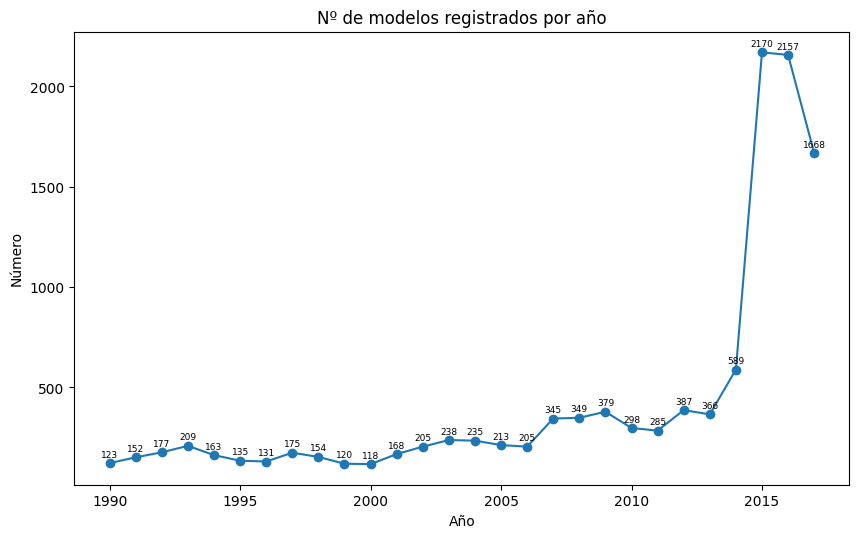

In [ ]:
#Agrupar observaciones por año
grupo_ano = automoviles[['Model','Year']].groupby(by='Year').count()
#Gráficar
figure(figsize=(10, 6), dpi=100)
anos = list(grupo_ano.index.values)
n_modelos = list(grupo_ano['Model'].values)
plt.plot(anos,n_modelos, marker='o') 
#Agrego nº por punto
for ano in range(0,len(n_modelos)):
    plt.annotate(s = n_modelos[ano], xy=(anos[ano],n_modelos[ano]+30), ha='center',fontsize=6.5)
plt.title('Nº de modelos registrados por año')
plt.ylabel('Número')
plt.xlabel('Año')
plt.show()

In [ ]:
#Variación del 2014 al 2015
print('La variación del 2014 al 2015 de la cantidad de datos es {:.0%}'.format(float(grupo_ano[grupo_ano.index==2015].values/grupo_ano[grupo_ano.index==2014].values)))

La variación del 2014 al 2015 de la cantidad de datos es 368%


<font color= 'orange'> **Observación:** </font>  Poseemos datos desde el año 1990 hasta el 2017, se debe considerar que a partir del año 2015 aumenta en un 368% la cantidad de modelos registrados en el set de datos, con respecto al 2014.

##### <font color= 'turquoise'> **Análisis Engine HP :** </font>  *Se visualizará variable Engine HP, que registra la potencia del motor también llamado caballos de fuerza*

In [ ]:
#Obtener estadísticas
enginehp = automoviles[['Engine HP']].dropna()
enginehpDetalle = enginehp.describe()
limitesEnginehp = outlierLimites(enginehp) #Límite inferior y superior para outliers
print(f'Rango de Engine Hp es {enginehp.max()-enginehp.min()}')
print(enginehpDetalle)

Rango de Engine Hp es Engine HP    946.0
dtype: float64
         Engine HP
count  11845.00000
mean     249.38607
std      109.19187
min       55.00000
25%      170.00000
50%      227.00000
75%      300.00000
max     1001.00000


In [ ]:
#Sin outliers
enginehpLimpio = enginehp.where(np.logical_and(enginehp > limitesEnginehp[0], enginehp < limitesEnginehp[1])).dropna() #Solo mantener valores que son mayores a límite inferior y menores a límite superior
enginehpLimpioDetalle = enginehpLimpio.describe()
print(f'Rango de Engine Hp sin outliers es {enginehpLimpio.max()-enginehpLimpio.min()}')
enginehpLimpioDetalle

Rango de Engine Hp sin outliers es Engine HP    438.0
dtype: float64


,Engine HP
count,11336.000000
mean,234.848536
std,85.775583
min,55.000000
25%,170.000000
50%,220.000000
75%,291.000000
max,493.000000


Text(0.5, 1.0, 'Comportamiento Engine Hp sin Outliers')

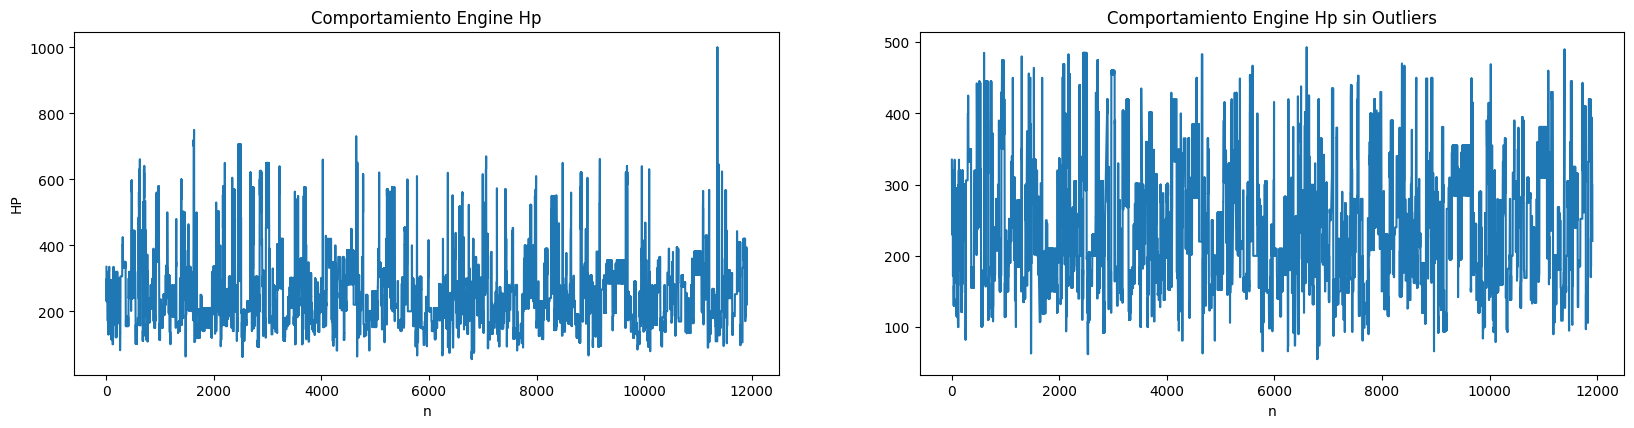

In [ ]:
#Gráfico
width = 0.2 #Tamaño boxplot
plt.figure(figsize=(20,10),dpi=100) #Figura de width=10, height=5

# Gráfico de linea
plt.subplot(221)
plt.plot(enginehp)
plt.ylabel('HP')
plt.xlabel('n')
plt.title('Comportamiento Engine Hp')

plt.subplot(222)
plt.plot(enginehpLimpio)
plt.xlabel('n')
plt.title('Comportamiento Engine Hp sin Outliers')

<font color= 'orange'> **Observación:** </font>  
La variable posee valores outliers ¿Errores en el dataset o modelos de lujo? Se verificará en gráfico bivariado.
Al quitarlos se puede ver que las observaciones están distirbuidas en un rango de 55 a 493 (con outliers llega a 1001), por lo que su rango también se ve afectado, bajando de 946 a 438.
En el caso del promedio al quitar outliers, la diferencia entre este y la mediana se disminuye de 22 a 14.
La desviación estándar es el estadístico más afectado, puesto que al eliminamos la mayoría de los valores por sobre 500.

##### <font color= 'turquoise'> **Análisis Engine Cylinders:** </font>  *Se visualizará variable Engine Cylinders, que registra el número de cilindros del motor*

In [ ]:
#Obtener estadísticas
enginecyl = automoviles[['Engine Cylinders']]
enginecylDetalle = enginecyl.describe()
limitesEnginecyl = outlierLimites(enginecyl) #Límite inferior y superior para outliers
print(f'Rango de Engine Cylinders es {enginecyl.max()-enginecyl.min()}')
print(enginecylDetalle)

Rango de Engine Cylinders es Engine Cylinders    16.0
dtype: float64
       Engine Cylinders
count      11884.000000
mean           5.628829
std            1.780559
min            0.000000
25%            4.000000
50%            6.000000
75%            6.000000
max           16.000000


In [ ]:
#Agrupar por numero de cilindros, puesto que no hay gran variabilidad
enginecyl_grupo = enginecyl.groupby(by='Engine Cylinders')['Engine Cylinders'].count()
enginecyl_grupo

Engine Cylinders
0.0       56
3.0       30
4.0     4752
5.0      225
6.0     4489
8.0     2031
10.0      68
12.0     230
16.0       3
Name: Engine Cylinders, dtype: int64

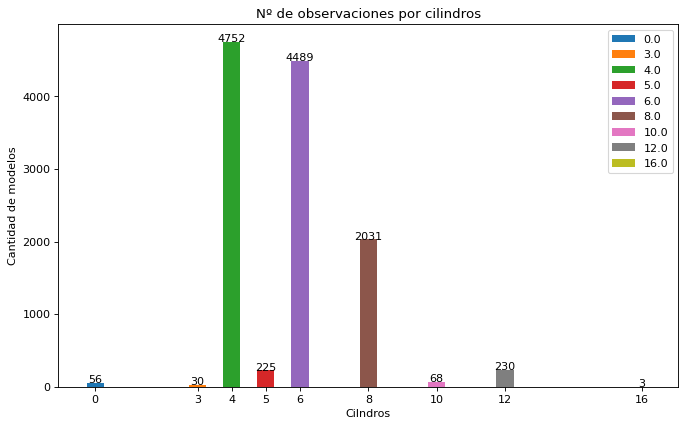

In [ ]:
#Graficar Nº de observaciones por cilindros
figure(figsize=(10, 6), dpi=80)
width = 0.50
cilindros = list(enginecyl_grupo.index.values) #Etiquetas por cilindros
n_modelos = list(enginecyl_grupo.values)  #Nº autos por cilindros
x = np.arange(len(cilindros)) #Longitud cilindros
plt.xticks(list(enginecyl_grupo.index.values)) #Mostrar grupos en eje X, puesto que 16 no se alcanza a visualizar por color
for index,value in enumerate(cilindros):
    plt.bar(cilindros[index],n_modelos[index],width) #Generar barra por cilindro
    plt.text(cilindros[index], n_modelos[index], str(n_modelos[index]), color='black', ha='center') #Ubicar cantidad sobre cada grupo
plt.legend(cilindros,loc='upper right') #Se posiciona leyenda del gráfico
plt.title('Nº de observaciones por cilindros')
plt.ylabel('Cantidad de modelos')
plt.xlabel('Cilndros')
plt.show()

In [ ]:
#¿Autos que no poseen cilindros?
automoviles[automoviles['Engine Cylinders']==0].head(5) #Corresponden a modelos electricos

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
539,FIAT,500e,2015,electric,NaN,0.0,DIRECT_DRIVE,front wheel drive,2.0,Hatchback,Compact,2dr Hatchback,108,122,819,31800
540,FIAT,500e,2016,electric,NaN,0.0,DIRECT_DRIVE,front wheel drive,2.0,Hatchback,Compact,2dr Hatchback,103,121,819,31800
541,FIAT,500e,2017,electric,NaN,0.0,DIRECT_DRIVE,front wheel drive,2.0,Hatchback,Compact,2dr Hatchback,103,121,819,31800
1680,Mercedes-Benz,B-Class Electric Drive,2015,electric,177.0,0.0,DIRECT_DRIVE,front wheel drive,4.0,"Hatchback,Luxury",Compact,4dr Hatchback,82,85,617,41450
1681,Mercedes-Benz,B-Class Electric Drive,2016,electric,177.0,0.0,DIRECT_DRIVE,front wheel drive,4.0,"Hatchback,Luxury",Compact,4dr Hatchback,82,85,617,41450


In [ ]:
automoviles[automoviles['Engine Cylinders']==16].head(5) #Corresponden a modelos exóticos

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
11362,Bugatti,Veyron 16.4,2008,premium unleaded (required),1001.0,16.0,AUTOMATED_MANUAL,all wheel drive,2.0,"Exotic,High-Performance",Compact,Coupe,14,8,820,2065902
11363,Bugatti,Veyron 16.4,2008,premium unleaded (required),1001.0,16.0,AUTOMATED_MANUAL,all wheel drive,2.0,"Exotic,High-Performance",Compact,Coupe,14,8,820,1500000
11364,Bugatti,Veyron 16.4,2009,premium unleaded (required),1001.0,16.0,AUTOMATED_MANUAL,all wheel drive,2.0,"Exotic,High-Performance",Compact,Coupe,14,8,820,1705769


<font color= 'orange'> **Observación:** </font>  En el set de datos, el nº de cilindros que más poseen los autos son 4, 6 y 8. El promedio del Nº de cilindro en los autos es cercano a la mediana, siendo 5.6 y 6 espectivamente. El número mínimo de cilindros es 0, que corresponde a automóviles electricos y el máximo es 16, que son modelos de lujo.

##### <font color= 'turquoise'> **Análisis Number of Doors	:** </font>  *Se visualizará variable Number of Doors, que registra el número de puertas de los automóviles*

In [ ]:
#Obtener estadísticas
doors = automoviles[['Number of Doors']]
doorsDetalle = doors.describe()
limitesDoors = outlierLimites(doors) #Límite inferior y superior para outliers
print(f'Rango de Number of Doors es {doors.max()-doors.min()}')
print(doorsDetalle)

Rango de Number of Doors es Number of Doors    2.0
dtype: float64
       Number of Doors
count     11908.000000
mean          3.436093
std           0.881315
min           2.000000
25%           2.000000
50%           4.000000
75%           4.000000
max           4.000000


In [ ]:
#Agrupar por numero de puertas, puesto que no hay gran variabilidad
doors_grupo = doors.groupby(by='Number of Doors')['Number of Doors'].count()
doors_grupo

Number of Doors
2.0    3160
3.0     395
4.0    8353
Name: Number of Doors, dtype: int64

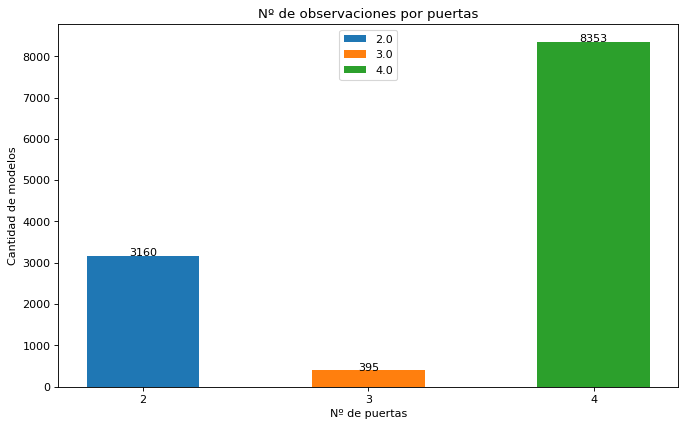

In [ ]:
#Graficar Nº de observaciones por puertas
figure(figsize=(10, 6), dpi=80)
width = 0.50
puertas = list(doors_grupo.index.values) #Etiquetas por puertas
n_puertas = list(doors_grupo.values)  #Nº autos por puertas
x = np.arange(len(puertas)) #Longitud puertas
plt.xticks(list(doors_grupo.index.values))
for index,value in enumerate(puertas):
    plt.bar(puertas[index],n_puertas[index],width) #Generar barra por puertas
    plt.text(puertas[index], n_puertas[index], str(n_puertas[index]), color='black', ha='center') #Ubicar cantidad sobre cada grupo
plt.legend(puertas,loc='upper center') #Se posiciona leyenda del gráfico
plt.title('Nº de observaciones por puertas')
plt.ylabel('Cantidad de modelos')
plt.xlabel('Nº de puertas')
plt.show()

In [ ]:
#Vehículos de 3 puertas?
automoviles['Vehicle Style'][automoviles['Number of Doors']==3].head(10).unique()

array(['Cargo Minivan', 'Passenger Minivan'], dtype=object)

<font color= 'orange'> **Observación:** </font>  En el set de datos, el nº de puertas que más poseen los modelos es 4. El número mínimo de puertas es 2 y el máximo es 4, vehículos de 3 puertas son los que se encuentran en menor cantidad y son del tipo Minivan.

##### <font color= 'turquoise'> **Análisis Highway MPG:** </font>  *Se visualizará variable Highway MPG, que indica cuantas millas puede recorrer un vehículo con un galón de combustible en carretera*

In [ ]:
#Obtener estadísticas
highway = automoviles['highway MPG']
highwayDetalle = highway.describe()
limitesHighway = outlierLimites(highway) #Límite inferior y superior para outliers
print(f'Rango de Highway MPG es {highway.max()-highway.min()}')
print(highwayDetalle)

Rango de Highway MPG es 342
count    11914.000000
mean        26.637485
std          8.863001
min         12.000000
25%         22.000000
50%         26.000000
75%         30.000000
max        354.000000
Name: highway MPG, dtype: float64


In [ ]:
#Sin outliers
highwayLimpio = highway.where(np.logical_and(highway > limitesHighway[0], highway < limitesHighway[1])).dropna() #Solo mantener valores que son mayores a límite inferior y menores a límite superior
highwayLimpioDetalle = highwayLimpio.describe()
print(f'Rango de Highway MPG es {highwayLimpio.max()-highwayLimpio.min()}')
highwayLimpioDetalle

Rango de Highway MPG es 29.0


count    11672.000000
mean        25.926062
std          5.910633
min         12.000000
25%         22.000000
50%         25.000000
75%         30.000000
max         41.000000
Name: highway MPG, dtype: float64

Text(0.5, 1.0, 'Histograma Highway MPG sin outliers')

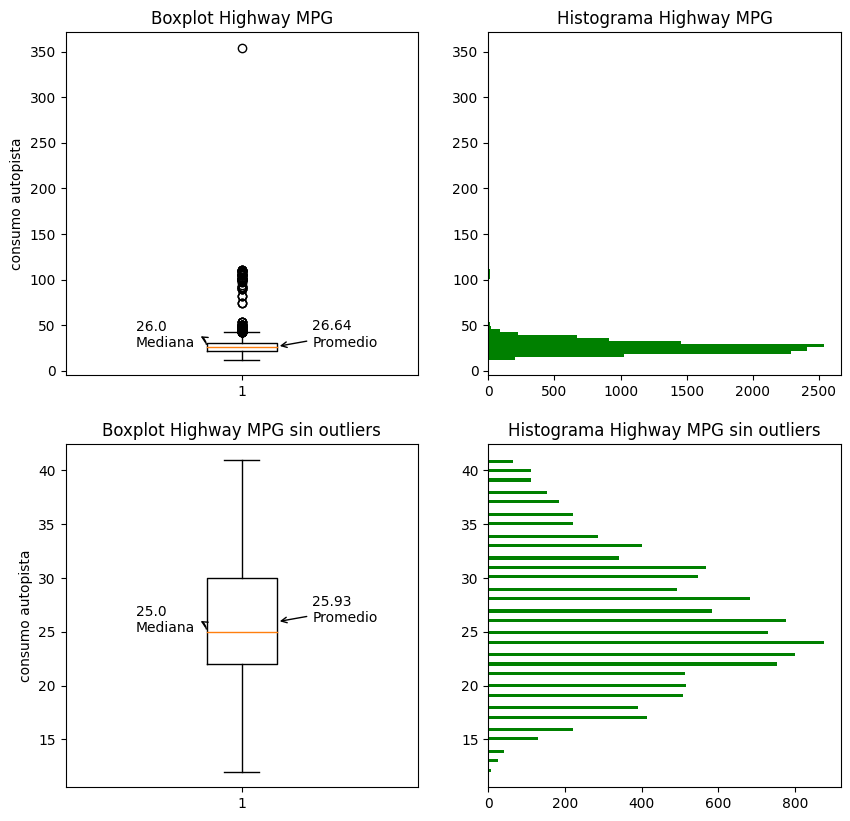

In [ ]:
#Gráfico
width = 0.2 #Tamaño boxplot
plt.figure(figsize=(10,10),dpi=100) #Figura de width=10, height=5

# Subplot msrp boxplot
plt.subplot(221)
plt.boxplot(highway,widths=width)
anotaciones(width,round(highwayDetalle[1],2),'data','Promedio','->') #Promedio
anotaciones(width,round(highwayDetalle[5],2),'data','Mediana','<-',0.8,0.5) #Mediana, lado contrario, inicia desde 0.8 flecha y llega a 0.5
plt.title('Boxplot Highway MPG')
plt.ylabel("consumo autopista")

#Subplot msrp histograma
plt.subplot(222)
plt.hist(highway, color='green',bins=100,orientation='horizontal')
plt.title('Histograma Highway MPG')

# Subplot msrp boxplot sin outliers
plt.subplot(223)
plt.boxplot(highwayLimpio,widths=width)
anotaciones(width,round(highwayLimpioDetalle[1],2),'data','Promedio','->') #Promedio
anotaciones(width,round(highwayLimpioDetalle[5],2),'data','Mediana','<-',0.8,0.5) #Mediana, lado contrario, inicia desde 0.8 flecha y llega a 0.5
plt.title('Boxplot Highway MPG sin outliers')
plt.ylabel("consumo autopista")
#Subplot msrp histograma sin outliers
plt.subplot(224)
plt.hist(highwayLimpio, color='green',bins=100,orientation='horizontal')
plt.title('Histograma Highway MPG sin outliers')


In [ ]:
#Outliers
highwayOutliers = highway.where(np.logical_or(highway <= limitesHighway[0], highway >= limitesHighway[1])).dropna() #Solo mantener valores que son mayores a límite inferior y menores a límite superior
highwayOutliers.describe()

count    242.000000
mean      60.950413
std       31.374687
min       42.000000
25%       43.000000
50%       46.000000
75%       88.000000
max      354.000000
Name: highway MPG, dtype: float64

In [ ]:
#Modelos con mayor rendimiento
automoviles[automoviles['highway MPG'].isin(highwayOutliers)].sort_values('highway MPG', ascending=False).head(10) #Audi A6 , error?

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
1119,Audi,A6,2017,premium unleaded (recommended),252.0,4.0,AUTOMATED_MANUAL,front wheel drive,4.0,Luxury,Midsize,Sedan,354,24,3105,51600
5792,BMW,i3,2017,electric,170.0,0.0,DIRECT_DRIVE,rear wheel drive,4.0,"Hatchback,Luxury",Compact,4dr Hatchback,111,137,3916,42400
5790,BMW,i3,2015,electric,170.0,0.0,DIRECT_DRIVE,rear wheel drive,4.0,"Hatchback,Luxury",Compact,4dr Hatchback,111,137,3916,42400
5791,BMW,i3,2016,electric,170.0,0.0,DIRECT_DRIVE,rear wheel drive,4.0,"Hatchback,Luxury",Compact,4dr Hatchback,111,137,3916,42400
1983,Chevrolet,Bolt EV,2017,electric,200.0,NaN,DIRECT_DRIVE,front wheel drive,4.0,Hatchback,Compact,4dr Hatchback,110,128,1385,40905
1984,Chevrolet,Bolt EV,2017,electric,200.0,NaN,DIRECT_DRIVE,front wheel drive,4.0,Hatchback,Compact,4dr Hatchback,110,128,1385,36620
9871,Chevrolet,Spark EV,2016,electric,140.0,0.0,DIRECT_DRIVE,front wheel drive,4.0,Hatchback,Compact,4dr Hatchback,109,128,1385,25510
9869,Chevrolet,Spark EV,2015,electric,140.0,0.0,DIRECT_DRIVE,front wheel drive,4.0,Hatchback,Compact,4dr Hatchback,109,128,1385,25170
9870,Chevrolet,Spark EV,2015,electric,140.0,0.0,DIRECT_DRIVE,front wheel drive,4.0,Hatchback,Compact,4dr Hatchback,109,128,1385,25560
9872,Chevrolet,Spark EV,2016,electric,140.0,0.0,DIRECT_DRIVE,front wheel drive,4.0,Hatchback,Compact,4dr Hatchback,109,128,1385,25120


<font color= 'orange'> **Observación:** </font> 
La variable Highway MPG, posee 242 valores outliers, que van desde el 42 hasta el 354 lo que no permite visualizar correctamente la distribución de la variable. Una vez que se eliminan del conjunto de datos se visualiza una distribución normal de los datos que tiende al 24.
El rendiminento promedio de los modelos en carrera es de 24-25 millas por galon, la mediana mantiene un comportamiento similar. El rendimiento mínimo es de 12 millas y con el máximo en el caso del set con outliers la diferencia es de 342, pero al quitar estos valores la diferencia se reduce a 29, siendo este un número más realista para generalizar. Los 10 modelos que obtienen los mejores resultados son del tipo electrico en su mayoría, la única excepción es el Audi A6, pero puede ser una medición erronea ya que la diferencia entre el consumo highway y city es considerablemente mayor, comparada con los otros modelos.

##### <font color= 'turquoise'> **Análisis City MPG:** </font>  *Se visualizará variable City mpg, que indica cuantas millas puede recorrer un vehículo con un galón de combustible en ciudad*

In [ ]:
#Obtener estadísticas
city = automoviles['city mpg']
cityDetalle = city.describe()
limitesCity = outlierLimites(city) #Límite inferior y superior para outliers
print(f'Rango de City MPG es {city.max()-city.min()}')
print(cityDetalle)

Rango de City MPG es 130
count    11914.000000
mean        19.733255
std          8.987798
min          7.000000
25%         16.000000
50%         18.000000
75%         22.000000
max        137.000000
Name: city mpg, dtype: float64


In [ ]:
#Sin outliers
cityLimpio = city.where(np.logical_and(city > limitesCity[0], city < limitesCity[1])).dropna() #Solo mantener valores que son mayores a límite inferior y menores a límite superior
cityLimpioDetalle = cityLimpio.describe()
print(f'Rango de City MPG es {cityLimpio.max()-cityLimpio.min()}')
cityLimpioDetalle

Rango de City MPG es 22.0


count    11475.000000
mean        18.624749
std          4.391033
min          8.000000
25%         15.000000
50%         18.000000
75%         22.000000
max         30.000000
Name: city mpg, dtype: float64

Text(0.5, 1.0, 'Histograma City MPG sin outliers')

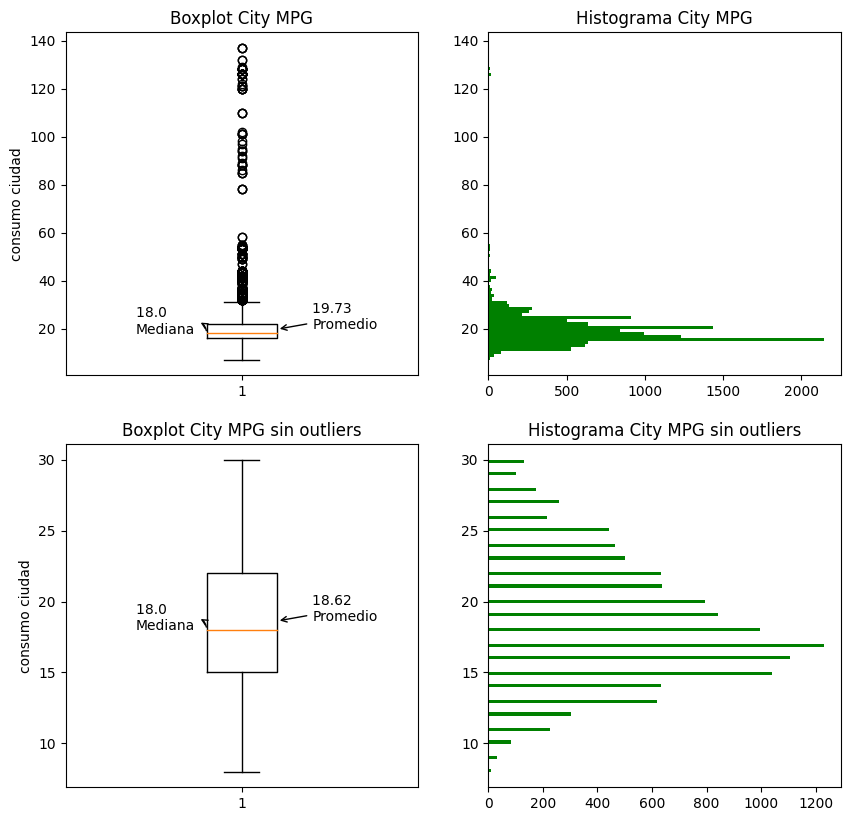

In [ ]:
#Gráfico
width = 0.2 #Tamaño boxplot
plt.figure(figsize=(10,10),dpi=100) #Figura de width=10, height=5

# Subplot city boxplot
plt.subplot(221)
plt.boxplot(city,widths=width)
anotaciones(width,round(cityDetalle[1],2),'data','Promedio','->') #Promedio
anotaciones(width,round(cityDetalle[5],2),'data','Mediana','<-',0.8,0.5) #Mediana, lado contrario, inicia desde 0.8 flecha y llega a 0.5
plt.title('Boxplot City MPG')
plt.ylabel("consumo ciudad")

#Subplot city histograma
plt.subplot(222)
plt.hist(city, color='green',bins=100,orientation='horizontal')
plt.title('Histograma City MPG')

# Subplot city boxplot sin outliers
plt.subplot(223)
plt.boxplot(cityLimpio,widths=width)
anotaciones(width,round(cityLimpioDetalle[1],2),'data','Promedio','->') #Promedio
anotaciones(width,round(cityLimpioDetalle[5],2),'data','Mediana','<-',0.8,0.5) #Mediana, lado contrario, inicia desde 0.8 flecha y llega a 0.5
plt.title('Boxplot City MPG sin outliers')
plt.ylabel("consumo ciudad")

#Subplot city histograma sin outliers
plt.subplot(224)
plt.hist(cityLimpio, color='green',bins=100,orientation='horizontal')
plt.title('Histograma City MPG sin outliers')


In [ ]:
#Outliers
cityOutliers = city.where(np.logical_or(city <= limitesCity[0], city >= limitesCity[1])).dropna() #Solo mantener valores que son mayores a límite inferior y menores a límite superior
cityOutliers.describe()

count    439.000000
mean      48.708428
std       28.606872
min        7.000000
25%       31.000000
50%       37.000000
75%       48.000000
max      137.000000
Name: city mpg, dtype: float64

In [ ]:
#Modelos con mayor rendimiento
automoviles[automoviles['city mpg'].isin(cityOutliers)].sort_values('city mpg', ascending=False).head(10)

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
5791,BMW,i3,2016,electric,170.0,0.0,DIRECT_DRIVE,rear wheel drive,4.0,"Hatchback,Luxury",Compact,4dr Hatchback,111,137,3916,42400
5790,BMW,i3,2015,electric,170.0,0.0,DIRECT_DRIVE,rear wheel drive,4.0,"Hatchback,Luxury",Compact,4dr Hatchback,111,137,3916,42400
5792,BMW,i3,2017,electric,170.0,0.0,DIRECT_DRIVE,rear wheel drive,4.0,"Hatchback,Luxury",Compact,4dr Hatchback,111,137,3916,42400
4705,Honda,Fit EV,2013,electric,NaN,0.0,DIRECT_DRIVE,front wheel drive,4.0,Hatchback,Compact,4dr Hatchback,105,132,2202,36625
4706,Honda,Fit EV,2014,electric,NaN,0.0,DIRECT_DRIVE,front wheel drive,4.0,Hatchback,Compact,4dr Hatchback,105,132,2202,36625
5793,BMW,i3,2017,electric,170.0,0.0,DIRECT_DRIVE,rear wheel drive,4.0,"Hatchback,Luxury",Compact,4dr Hatchback,106,129,3916,43600
1984,Chevrolet,Bolt EV,2017,electric,200.0,NaN,DIRECT_DRIVE,front wheel drive,4.0,Hatchback,Compact,4dr Hatchback,110,128,1385,36620
9872,Chevrolet,Spark EV,2016,electric,140.0,0.0,DIRECT_DRIVE,front wheel drive,4.0,Hatchback,Compact,4dr Hatchback,109,128,1385,25120
9871,Chevrolet,Spark EV,2016,electric,140.0,0.0,DIRECT_DRIVE,front wheel drive,4.0,Hatchback,Compact,4dr Hatchback,109,128,1385,25510
9870,Chevrolet,Spark EV,2015,electric,140.0,0.0,DIRECT_DRIVE,front wheel drive,4.0,Hatchback,Compact,4dr Hatchback,109,128,1385,25560


<font color= 'orange'> **Observación:** </font> 
La variable City MPG, posee 439 valores outliers, que llegan hasta el 137 lo que no permite visualizar correctamente la distribución de la variable. Una vez que se eliminan del conjunto de datos se visualiza una distribución normal de los datos que tiende al 17.
El rendimiento promedio de los modelos en ciudad es de 18-19 millas por galon, la mediana mantiene un comportamiento similar y no se ve afectada por los outliers. 
El rendimiento mínimo es de 7-8 millas y con el máximo en el caso del set con outliers la diferencia es de 130, pero al quitar estos valores la diferencia se reduce a 22, siendo este un número más realista para generalizar. Los 10 modelos que obtienen los mejores resultados son del tipo electrico.

##### <font color= 'turquoise'> **Análisis Popularity:** </font>  *Se visualizará variable Popularity, que indica la popularidad del modelo registrado*

In [ ]:
#Obtener estadísticas
popularity = automoviles['Popularity']
popularityDetalle = popularity.describe()
limitesPopularity = outlierLimites(popularity) #Límite inferior y superior para outliers
print(f'Rango de Popularity es {popularity.max()-popularity.min()}')
print(popularityDetalle)

Rango de Popularity es 5655
count    11914.000000
mean      1554.911197
std       1441.855347
min          2.000000
25%        549.000000
50%       1385.000000
75%       2009.000000
max       5657.000000
Name: Popularity, dtype: float64


In [ ]:
#Sin outliers
popularityLimpio = popularity.where(np.logical_and(popularity > limitesPopularity[0], popularity < limitesPopularity[1])).dropna() #Solo mantener valores que son mayores a límite inferior y menores a límite superior
popularityLimpioDetalle = popularityLimpio.describe()
print(f'Rango de Popularity es {popularityLimpio.max()-popularityLimpio.min()}')
popularityLimpioDetalle

Rango de Popularity es 3914.0


count    11033.000000
mean      1227.353848
std        890.996035
min          2.000000
25%        549.000000
50%       1013.000000
75%       1851.000000
max       3916.000000
Name: Popularity, dtype: float64

Text(0.5, 1.0, 'Histograma Popularity sin outliers')

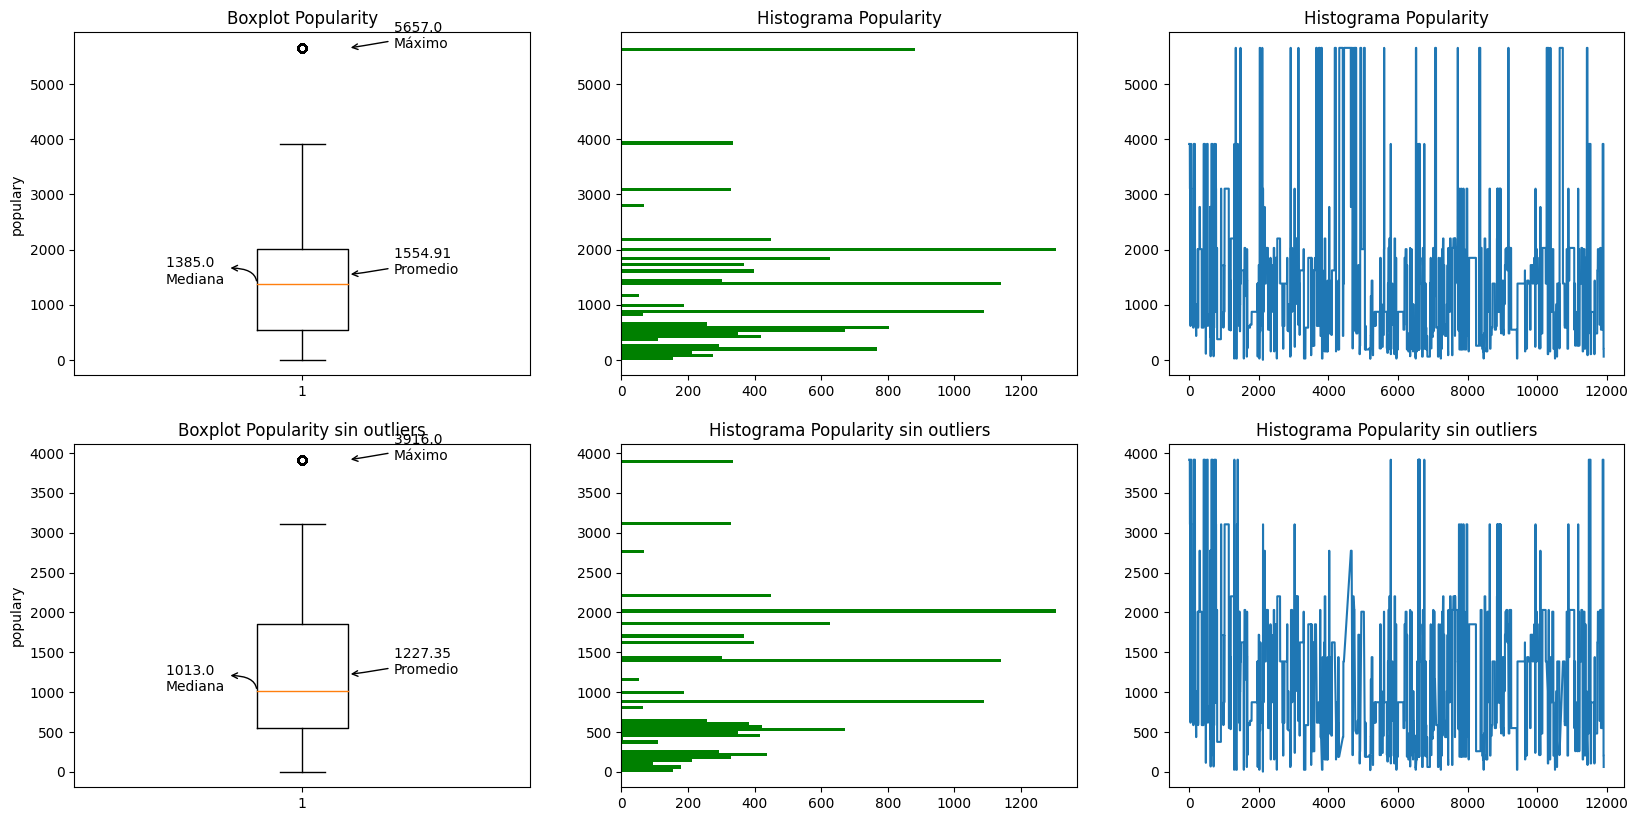

In [ ]:
#Gráfico
width = 0.2 #Tamaño boxplot
plt.figure(figsize=(20,10),dpi=100) #Figura de width=10, height=5

# Subplot popularity boxplot
plt.subplot(231)
plt.boxplot(popularity,widths=width)
anotaciones(width,round(popularityDetalle[1],2),'data','Promedio','->') #Promedio
anotaciones(width,round(popularityDetalle[7],2),'data','Máximo','->') #Máximo
plt.ylabel("populary")
anotaciones(width,round(popularityDetalle[5],2),'data','Mediana','<-',0.8,0.5) #Mediana, lado contrario, inicia desde 0.8 flecha y llega a 0.5
plt.title('Boxplot Popularity')

#Subplot popularity histograma
plt.subplot(232)
plt.hist(popularity, color='green',bins=100,orientation='horizontal')
plt.title('Histograma Popularity')

#Subplot popularity linea
plt.subplot(233)
plt.plot(popularity)
plt.title('Histograma Popularity')

# Subplot popularity boxplot sin outliers
plt.subplot(234)
plt.boxplot(popularityLimpio,widths=width)
anotaciones(width,round(popularityLimpioDetalle[1],2),'data','Promedio','->') #Promedio
anotaciones(width,round(popularityLimpioDetalle[7],2),'data','Máximo','->') #Máximo
anotaciones(width,round(popularityLimpioDetalle[5],2),'data','Mediana','<-',0.8,0.5) #Mediana, lado contrario, inicia desde 0.8 flecha y llega a 0.5
plt.title('Boxplot Popularity sin outliers')
plt.ylabel("populary")

#Subplot popularity histograma sin outliers
plt.subplot(235)
plt.hist(popularityLimpio, color='green',bins=100,orientation='horizontal')
plt.title('Histograma Popularity sin outliers')

#Subplot popularity linea sin outliers
plt.subplot(236)
plt.plot(popularityLimpio)
plt.title('Histograma Popularity sin outliers')

In [ ]:
#Outliers
popularityOutliers = popularity.where(np.logical_or(popularity <= limitesPopularity[0], popularity >= limitesPopularity[1])).dropna() #Solo mantener valores que son mayores a límite inferior y menores a límite superior
popularityOutliers.describe()

count     881.0
mean     5657.0
std         0.0
min      5657.0
25%      5657.0
50%      5657.0
75%      5657.0
max      5657.0
Name: Popularity, dtype: float64

In [ ]:
#Modelos con mayor popularidad
automoviles[automoviles['Popularity'].isin(popularityOutliers)].sort_values('Popularity', ascending=False).head(10)

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
1331,Ford,Aerostar,1995,regular unleaded,135.0,6.0,AUTOMATIC,rear wheel drive,3.0,NaN,Midsize,Cargo Minivan,22,16,5657,2000
5023,Ford,Fusion Hybrid,2016,regular unleaded,188.0,4.0,AUTOMATIC,front wheel drive,4.0,Hybrid,Midsize,Sedan,41,44,5657,31430
4936,Ford,Freestyle,2006,regular unleaded,203.0,6.0,AUTOMATIC,front wheel drive,4.0,Crossover,Large,Wagon,25,18,5657,25105
4937,Ford,Freestyle,2006,regular unleaded,203.0,6.0,AUTOMATIC,all wheel drive,4.0,Crossover,Large,Wagon,22,17,5657,30580
4938,Ford,Freestyle,2006,regular unleaded,203.0,6.0,AUTOMATIC,all wheel drive,4.0,Crossover,Large,Wagon,22,17,5657,26955
4939,Ford,Freestyle,2006,regular unleaded,203.0,6.0,AUTOMATIC,front wheel drive,4.0,Crossover,Large,Wagon,25,18,5657,28530
4940,Ford,Freestyle,2007,regular unleaded,203.0,6.0,AUTOMATIC,all wheel drive,4.0,Crossover,Large,Wagon,22,17,5657,27770
4941,Ford,Freestyle,2007,regular unleaded,203.0,6.0,AUTOMATIC,front wheel drive,4.0,Crossover,Large,Wagon,25,18,5657,29205
4942,Ford,Freestyle,2007,regular unleaded,203.0,6.0,AUTOMATIC,all wheel drive,4.0,Crossover,Large,Wagon,22,17,5657,31055
4943,Ford,Freestyle,2007,regular unleaded,203.0,6.0,AUTOMATIC,front wheel drive,4.0,Crossover,Large,Wagon,25,18,5657,25920


In [ ]:
#Agrupar por popularidad y modelo bins 
bins = np.arange(0,popularityDetalle[7]+500,500)
groups = automoviles.groupby(['Make', pd.cut(automoviles['Popularity'], bins)])
groups.size().unstack()

Popularity,"(0.0, 500.0]","(500.0, 1000.0]","(1000.0, 1500.0]","(1500.0, 2000.0]","(2000.0, 2500.0]","(2500.0, 3000.0]","(3000.0, 3500.0]","(3500.0, 4000.0]","(4000.0, 4500.0]","(4500.0, 5000.0]","(5000.0, 5500.0]","(5500.0, 6000.0]"
Make,,,,,,,,,,,,
Acura,252,0,0,0,0,0,0,0,0,0,0,0
Alfa Romeo,5,0,0,0,0,0,0,0,0,0,0,0
Aston Martin,93,0,0,0,0,0,0,0,0,0,0,0
Audi,0,0,0,0,0,0,328,0,0,0,0,0
BMW,0,0,0,0,0,0,0,334,0,0,0,0
Bentley,0,74,0,0,0,0,0,0,0,0,0,0
Bugatti,0,3,0,0,0,0,0,0,0,0,0,0
Buick,196,0,0,0,0,0,0,0,0,0,0,0
Cadillac,0,0,0,397,0,0,0,0,0,0,0,0


In [ ]:
#Agrupar datos por bins
groups.size().groupby('Popularity').sum()

Popularity
(0.0, 500.0]        2589
(500.0, 1000.0]     2887
(1000.0, 1500.0]    1683
(1500.0, 2000.0]    1390
(2000.0, 2500.0]    1753
(2500.0, 3000.0]      69
(3000.0, 3500.0]     328
(3500.0, 4000.0]     334
(4000.0, 4500.0]       0
(4500.0, 5000.0]       0
(5000.0, 5500.0]       0
(5500.0, 6000.0]     881
dtype: int64

<font color= 'orange'> **Observación:** </font> 
La variable Popularity presenta un cambio en sus estadísticos al realizar la comparación con y sin outliers. La visualización, no se ve mejorada, puesto que la variabildad de esta variable es alta, lo podemos apreciar en su desviación estándar que llega a 1441 en bruto y sin outliers disminuye a 890. No se presenta una distribución normal de los datos, se encuentra cargada entre los valores 0 a 2000.
La mayor popularidad se presenta en los modelos Ford, alcanzando el valor de 5657, teniendo una diferencia de 5655 con el de menor popularidad. El mayor número de autos se encuentra entre 500 y 1000 de popularidad (si agrupamos cada 500), y desde 2500 al valor mínimo encontramos la mayor concentración, aunque el 50% de los datos se concentra entorno al 1385.

##### <font color= 'turquoise'> **Análisis MSRP:** </font>  *Se visualizará variable MSRP, que registra el precio del auto sugerido por el fabricante*

In [ ]:
#Obtener estadísticas
msrp = automoviles['MSRP']
msrpDetalle = msrp.describe()
limitesMsrp = outlierLimites(msrp) #Límite inferior y superior para outliers
print(f'Rango de MSRP es {msrp.max()-msrp.min()}')
print(msrpDetalle)

Rango de MSRP es 2063902
count    1.191400e+04
mean     4.059474e+04
std      6.010910e+04
min      2.000000e+03
25%      2.100000e+04
50%      2.999500e+04
75%      4.223125e+04
max      2.065902e+06
Name: MSRP, dtype: float64


In [ ]:
#Sin outliers
msrpLimpio = msrp.where(np.logical_and(msrp > limitesMsrp[0], msrp < limitesMsrp[1])).dropna() #Solo mantener valores que son mayores a límite inferior y menores a límite superior
mrspLimpioDetalle = msrpLimpio.describe()
mrspLimpioDetalle

count    10918.000000
mean     28671.733284
std      15944.446640
min       2000.000000
25%      20095.000000
50%      28472.500000
75%      38198.750000
max      74000.000000
Name: MSRP, dtype: float64

Text(0.5, 1.0, 'Histograma MSRP sin outliers')

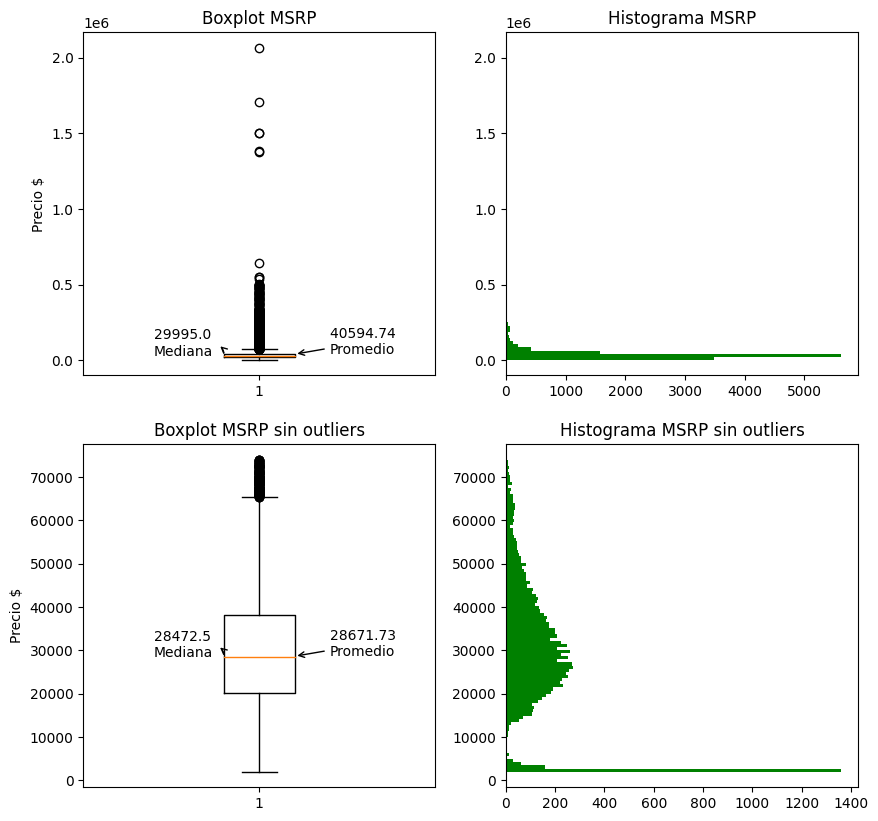

In [ ]:
#Gráfico
width = 0.2 #Tamaño boxplot
plt.figure(figsize=(10,10),dpi=100) #Figura de width=10, height=5

# Subplot msrp boxplot
plt.subplot(221)
plt.boxplot(msrp,widths=width)
anotaciones(width,round(msrpDetalle[1],2),'data','Promedio','->') #Promedio
anotaciones(width,round(msrpDetalle[5],2),'data','Mediana','<-',0.8,0.5) #Mediana, lado contrario, inicia desde 0.8 flecha y llega a 0.5
plt.title('Boxplot MSRP')
plt.ylabel('Precio $')

#Subplot msrp histograma
plt.subplot(222)
plt.hist(msrp, color='green',bins=100,orientation='horizontal')
plt.title('Histograma MSRP')

# Subplot msrp boxplot sin outliers
plt.subplot(223)
plt.boxplot(msrpLimpio,widths=width)
anotaciones(width,round(mrspLimpioDetalle[1],2),'data','Promedio','->') #Promedio
anotaciones(width,round(mrspLimpioDetalle[5],2),'data','Mediana','<-',0.8,0.5) #Mediana, lado contrario, inicia desde 0.8 flecha y llega a 0.5
plt.title('Boxplot MSRP sin outliers')
plt.ylabel('Precio $')


#Subplot msrp histograma sin outliers
plt.subplot(224)
plt.hist(msrpLimpio, color='green',bins=100,orientation='horizontal')
plt.title('Histograma MSRP sin outliers')


In [ ]:
#Obtener promedio de precio vehículo por año
grupo_precio = automoviles[['MSRP','Year']].groupby(by='Year').mean()
grupo_precio

,MSRP
Year,
1990,2020.203252
1991,2080.657895
1992,2077.740113
1993,2187.325359
1994,2312.030675
1995,2606.777778
1996,2497.366412
1997,3105.211429
1998,2975.597403


In [ ]:
#Outliers
msrpOutliers = msrp.where(np.logical_or(msrp <= limitesMsrp[0], msrp >= limitesMsrp[1])).dropna() #Solo mantener valores que son mayores a límite inferior y menores a límite superior
msrpOutliers.describe()

count    9.960000e+02
mean     1.712929e+05
std      1.476849e+05
min      7.410000e+04
25%      8.957500e+04
50%      1.252500e+05
75%      2.096975e+05
max      2.065902e+06
Name: MSRP, dtype: float64

<font color= 'orange'> **Observación:** </font>  El precio de los modelos aparentemente no posee una distribución normal, pero se observa una tendencia a 25.000 dolares. Se podría deber al rango de años del set de datos 1990-2017, puesto que hay una variación de 44.000 dolares en el valor promedio desde 1990 a 2015, año en que la cantidad de observaciones aumenta en más de un 300%. Al eliminar outliers la mediana y la media se acercan, puesto que eliminamos 996 que llegaban a un valor máximo de 2.065.902 dolares.

##### <font color= 'turquoise'> **Análisis Extra:** </font>  *Variable Market Category posee múltiples valores por cada observación, por lo que se hará una visualización individual*

In [ ]:
automoviles[["Market Category"]].tail(5)

,Market Category
11909,"Crossover,Hatchback,Luxury"
11910,"Crossover,Hatchback,Luxury"
11911,"Crossover,Hatchback,Luxury"
11912,"Crossover,Hatchback,Luxury"
11913,Luxury


In [ ]:
#Contador individual por categoría de mercado
cat_individual = []
for row in automoviles[["Market Category"]].dropna().itertuples(): #Sin nulos
   categorias = row[1].split(',') #Separar observaciones que poseen múltiples categorías
   for categoria in range(0,len(categorias)): #Recorrer categorías
       cat_individual.append(categorias[categoria]) #Agregar a lista
cat_individual = pd.DataFrame(cat_individual,columns=['Market Category']) #Convierte en dataframe
#Agrupar para graficar
cat_grupo = cat_individual.groupby(by='Market Category')['Market Category'].count()

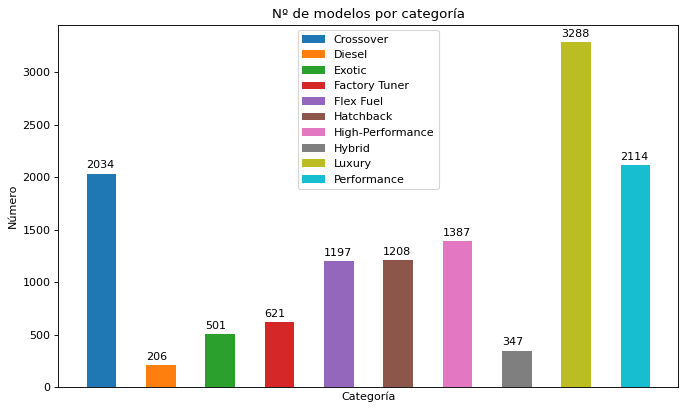

In [ ]:
#Graficar Nº de autos por categoría
figure(figsize=(10, 6), dpi=80)
width = 0.50
categorias = list(cat_grupo.index.values) #Etiquetas por categoria
n_categorias = list(cat_grupo.values)  #Nº autos por categoria
x = np.arange(len(categorias)) #Longitud categorias
plt.xticks([]) #No mostrar nombres en eje x
for index,value in enumerate(categorias):
    plt.bar(categorias[index],n_categorias[index],width) #Generar barra por categoría
    plt.text(index-0.25, n_categorias[index]+50, str(n_categorias[index]), color='black') #Ubicar cantidad sobre cada categoría
plt.legend(categorias,loc='upper center') #Se posiciona leyenda del gráfico
plt.title('Nº de modelos por categoría')
plt.ylabel('Número')
plt.xlabel('Categoría')
plt.show()

<font color= 'orange'> **Observación:** </font>  En el set de datos, las 3 categorías que poseen un mayor nº de modelos asociados son Luxury, Performance y Crossover

#### ANÁLISIS BIVARIADO

##### <font color= 'turquoise'> **Análisis Correlación:** </font> 

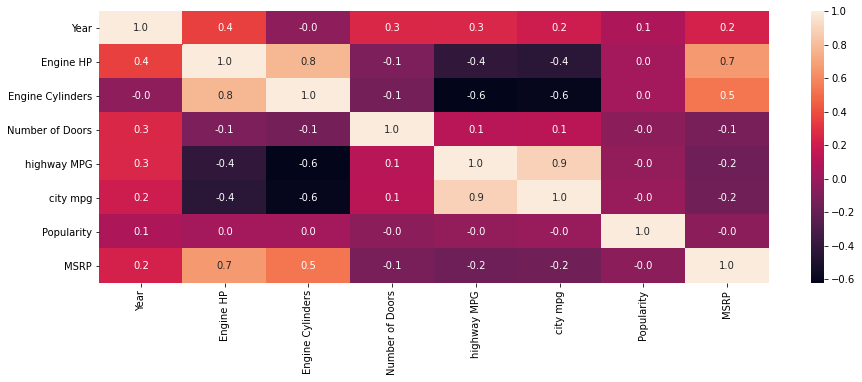

In [ ]:
#Correlación entre variables
automoviles_corr = automoviles.corr() 
plt.figure(figsize=(15,5))
sns.heatmap(automoviles_corr,annot=True, fmt='.1f') #Se genera heatmap
plt.show()

<font color= 'orange'> **Observación:** </font>  La variable dependiente para nuestro caso es MSRP, por lo que debemos evaluar su correlación con las otras variables para su posterior análisis y la confección de la regresión lineal.

Correlaciones altas
*   Engine Hp -> Positiva
*   Engine Cylinders -> Positiva

Correlaciones bajas
*   Year -> Positiva
*   Higway MPG -> Negativa
*   City MPG -> Negativa
*   Number of Doors -> Negativa

Correlaciones nulas
*   Popularity




##### <font color= 'turquoise'> **Análisis Engine Hp y Cylinders:** </font> 

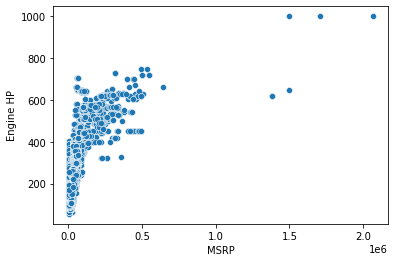

In [ ]:
#Gráfico de dispersión de la variable Engine HP
automoviles1 = automoviles[['MSRP', 'Engine HP']].dropna()  #Borramos los valores nulos de ambas columnas para una mejor visualización de los datos
sns.scatterplot(x='MSRP', y ='Engine HP',data=automoviles1)
plt.show()

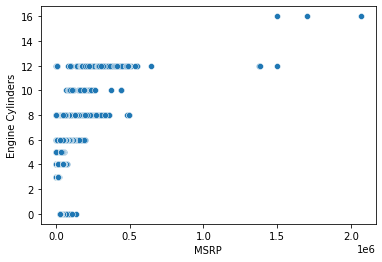

In [ ]:
#Graficamos la variable Engine Cylinders
automoviles2 = automoviles[['MSRP', 'Engine Cylinders']].dropna()  #Borramos los valores nulos de ambas columnas para una mejor viualización de los datos
sns.scatterplot(x='MSRP', y = 'Engine Cylinders',data=automoviles2)
plt.show()

<font color= 'orange'> **Observación:** </font>  Podemos visualizar que la variable Engine HP es continua, mientras la variable Engine Cylinders es discreta. Ambas variables necesitan tratamiento de outliers para poder evaluar si existe o no una tendencia lineal. Por el momento se puede visualizar que en ambas variables, a medida que una va aumentando MSRP también lo hace.

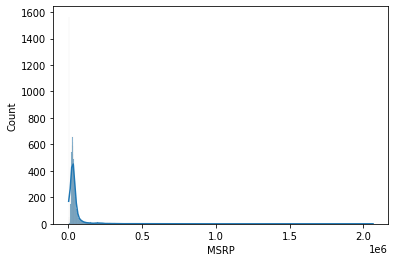

In [ ]:
#Visualizamos un histograma
sns.histplot(x='MSRP', data = automoviles, kde=True)
plt.show()

#### REGRESIÓN LINEAL

<font color= 'orange'> **Elección de la variable independiente:** </font>Comenzaremos con una Regresión Lineal simple de la variable independiente con mayor correlacion (Engine HP), con la variable dependiente (MSRP).

In [ ]:
automoviles1 = automoviles[['MSRP', 'Engine HP']].dropna()   #se elimnaron todas las filas con al menos un dato invalido
engine1 = automoviles1[['Engine HP']]
MSRP1 = automoviles1[['MSRP']]
automoviles1.where((engine1 > limitesEnginehp[0]) & (engine1 < limitesEnginehp[1]),inplace=True)
automoviles1.where((MSRP1 > limitesMsrp[0]) & (MSRP1 < limitesMsrp[1]),inplace=True)
automoviles1 = automoviles1.dropna()
automoviles1

,MSRP,Engine HP
0,46135.0,335.0
1,40650.0,300.0
2,36350.0,300.0
3,29450.0,230.0
4,34500.0,230.0
...,...,...
11909,46120.0,300.0
11910,56670.0,300.0
11911,50620.0,300.0
11912,50920.0,300.0


Visualizamos un Boxplot con el fin de confirmar que los Outliers fueron bien definidos

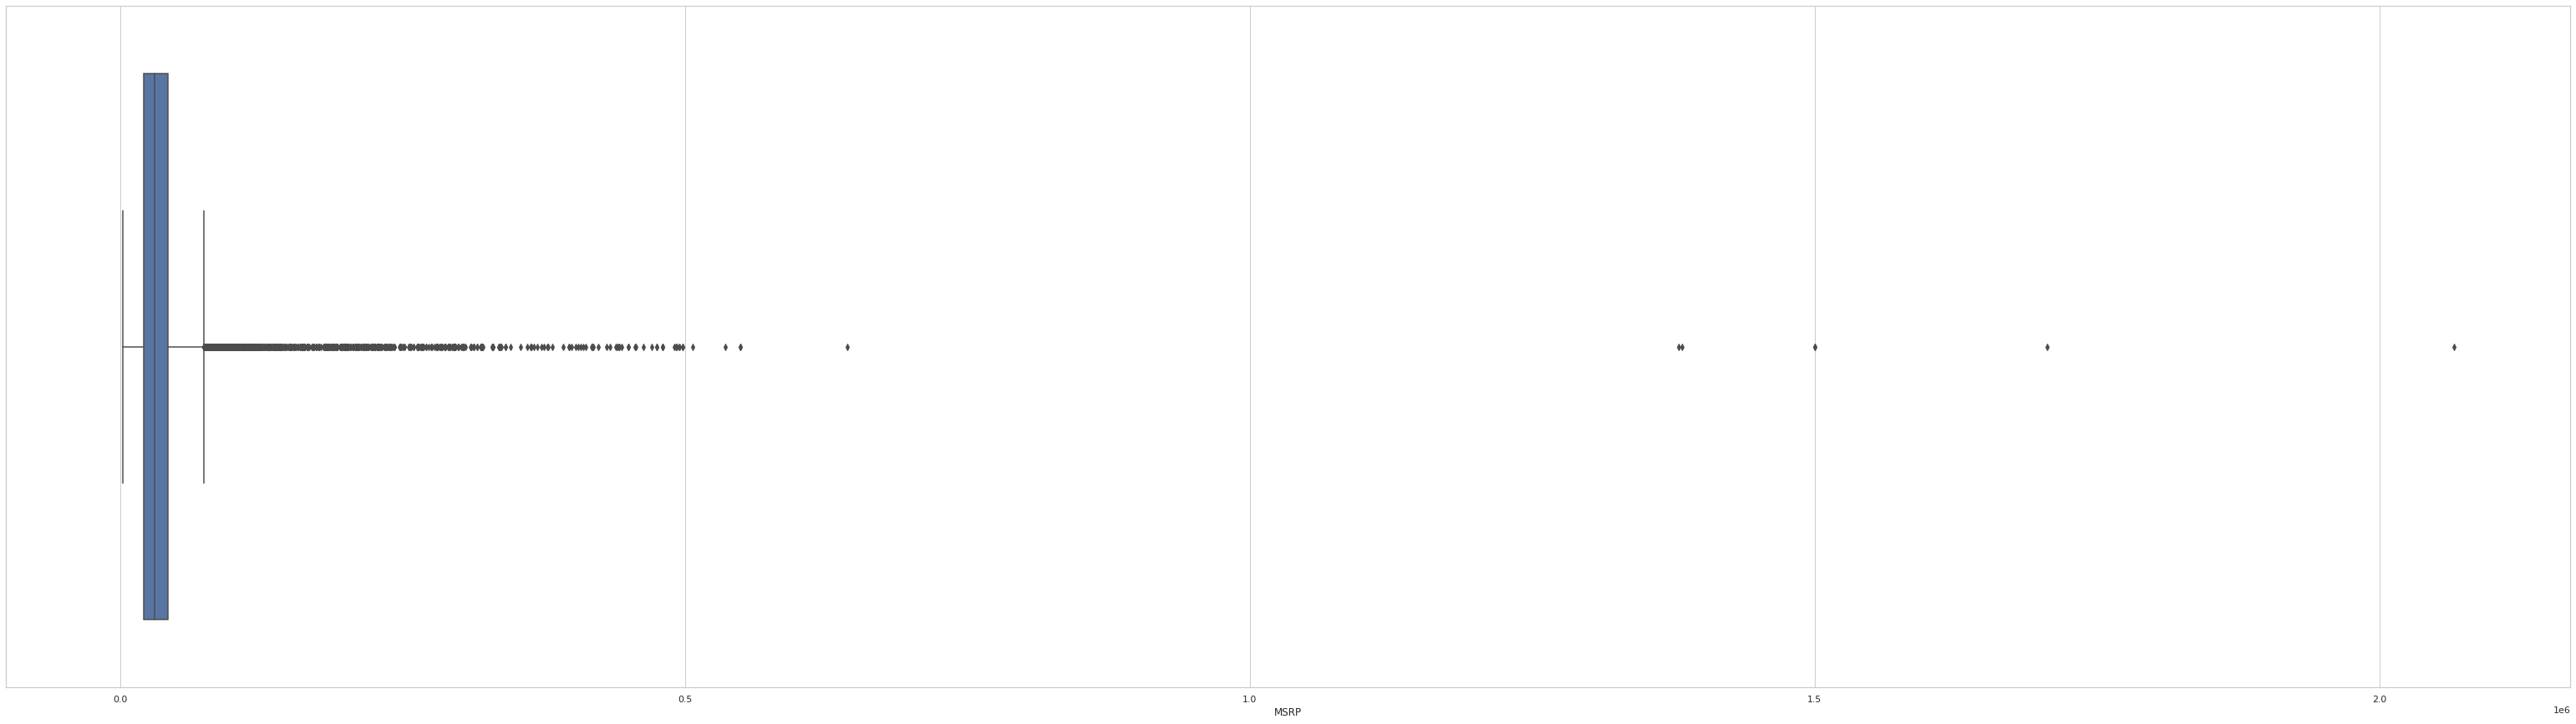

In [ ]:
plt.figure(figsize=(55,15))
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x=automoviles["MSRP"])

In [ ]:
print(f'El limite inferior es: {limitesMsrp[0]}')   #Cuartil 1
print(f'El limite superior es: {limitesMsrp[1]}')   #Cuartil 3

El limite inferior es: -10846.875
El limite superior es: 74078.125


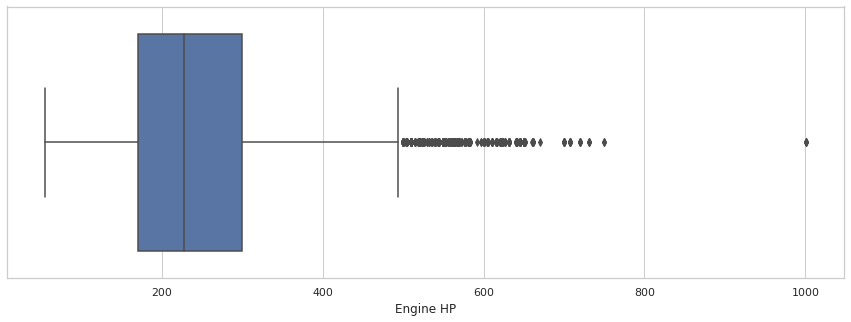

In [ ]:
plt.figure(figsize=(15,5))
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x=automoviles["Engine HP"])

In [ ]:
print(f'El limite inferior es: {limitesEnginehp[0]}')   #Cuartil 1
print(f'El limite superior es: {limitesEnginehp[1]}')   #Cuartil 3

El limite inferior es: Engine HP   -25.0
dtype: float64
El limite superior es: Engine HP    495.0
dtype: float64


Una vez confirmado y sacado los outliers, graficamos

In [ ]:
x = automoviles1['Engine HP']   #asignamos x
y = automoviles1['MSRP']     #asignamos y

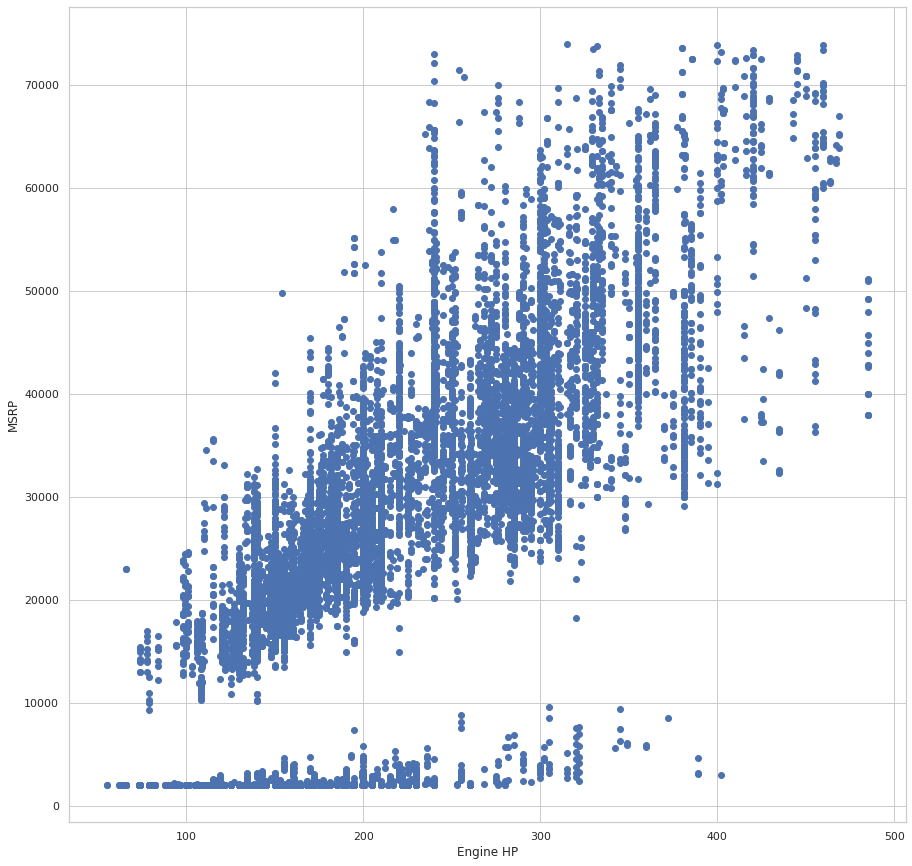

In [ ]:
plt.figure(figsize=(15,15))
plt.scatter(x,y) # Grafiquemos como se ven nuestros datos.
plt.ylabel('MSRP')
plt.xlabel("Engine HP")
plt.show()

Obtenemos los beta

In [ ]:
#Calcular beta 1
def calcularbeta1(x,y):
    x_min_mx = x - np.mean(x)  # x minus mean(x)
    y_min_my = y - np.mean(y)  # y minus mean(y)
    beta_1 = np.sum(x_min_mx * y_min_my)  / np.sum(x_min_mx**2)   #funcion de beta 1
    return beta_1

#Calcular beta 0
def calcularbeta0(beta_1,x,y):
    beta_0 = np.mean(y) - (beta_1 * np.mean(x))   #funcion de beta 0 
    return beta_0

#LLamaremos a esta función, lin_reg(x), recibe el vector y utiliza las variables betas calculadas anteriormente
def lin_reg(x,beta_1,beta_0): # Una posible mejora, es que reciba los betas por parametros de la función
    y_hat = (beta_1 * x) + beta_0 #Aplicamos la forma de la regresión lineal 
    return y_hat

beta_1 = calcularbeta1(x,y)
beta_0 = calcularbeta0(beta_1,x,y)

In [ ]:
def lin_reg(x): # Una posible mejora, es que reciba los betas por parametros de la función
    y_hat = (beta_1 * x) + beta_0 #Aplicamos la forma de la regresión lineal 
    return y_hat

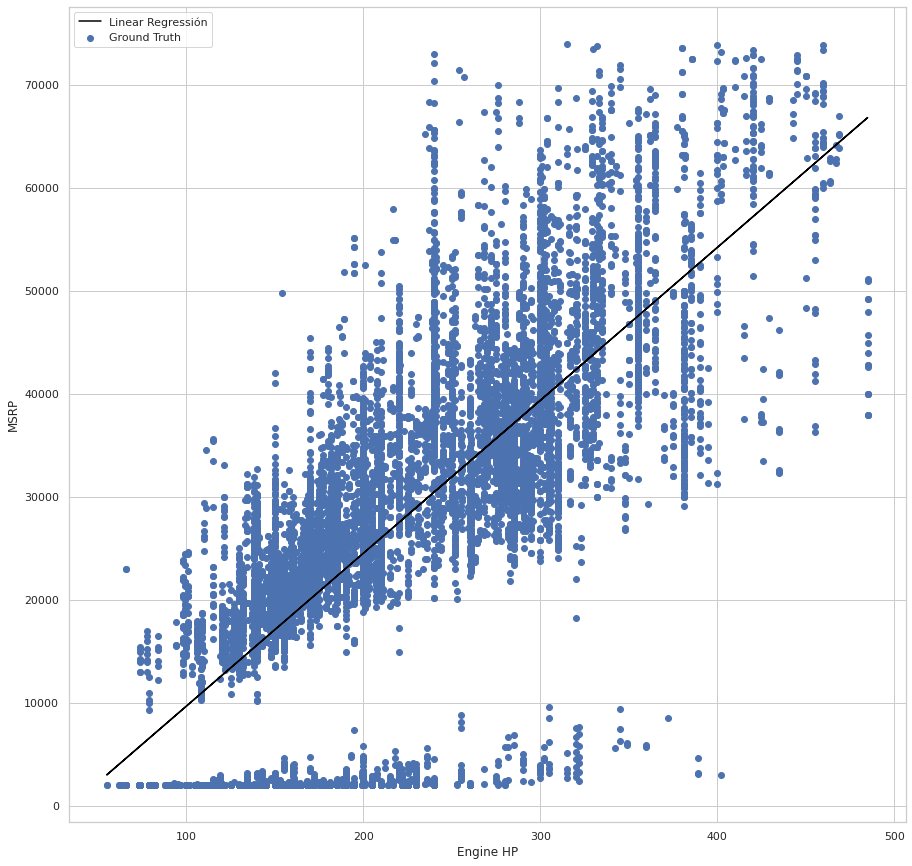

In [ ]:
plt.figure(figsize=(15,15))
plt.scatter(x,y,label="Ground Truth") # Vamos a gráficar nuestros datos originales 
plt.plot(x,lin_reg(x), color="black", label="Linear Regressión") #Luego graficamos la curva ajustada 
plt.ylabel('MSRP')
plt.xlabel("Engine HP")
plt.legend()
plt.show()

In [ ]:
SST = np.sum((y - np.mean(y))**2) #Calculamos la suma total de los cuadrados que mide la variabilidad total de y
SSE = np.sum((y - lin_reg(x))**2) # Calculamos la suma de los errores cuadrados
R2 = 1 - (SSE/SST) # Computamos el R^2

print("El R^2 obtenido para nuestros datos sinteticos es de {}".format(R2.round(4)))

El R^2 obtenido para nuestros datos sinteticos es de 0.5396


El R2 que obtenermos es bastante bajo, por lo que con estos datos de la variable independiente solo explicamos en un 53% la variable dependiente

In [ ]:
mse = np.sum((y - lin_reg(x))**2) / len(y)   #MSE indica que tan bueno es nuestro modelo con respecto a los valores atipicos.
mae = np.sum(np.abs(y - lin_reg(x))) / len(y)   #MAE magnitud del promedio de los residuos, da vision general de como podria comportarse la regresion.
mape = np.sum(np.abs((y - lin_reg(x))/y)) / len(y)   #MAPE indica porcentualmente que tanto se alejan nuestros valores predichos de los reales.

In [ ]:
print(f'MSE es: {mse} \nMAE es: {mae} \nMAPE es: {mape}')

MSE es: 115775887.4470596 
MAE es: 8017.782281167607 
MAPE es: 1.2831353675179047


Obtenemos un MSE y MAE alto, lo cual indica que nuestro modelo no es bueno
EL MAPE que indica un porcentaje de error es de sobre 100%, lo que indica que el modelo no es bueno


<font color= 'orange'> **Entonces, como podemos mejorar el modelo de Regresion lineal Simple?** </font>

Primero intentaremos utilizando automoviles desde el 2015 en adelante

In [ ]:
automoviles2 = automoviles[['MSRP', 'Engine HP', 'Year']].dropna()   #se elimnaron todas las filas con al menos un dato invalido
MSRP2 = automoviles2[['MSRP']]
engine2 = automoviles[['Engine HP']]
year1 = automoviles2[['Year']]
automoviles2.where((engine2 > limitesEnginehp[0]) & (engine2 < limitesEnginehp[1]),inplace=True)
automoviles2.where((MSRP2 > limitesMsrp[0]) & (MSRP2 < limitesMsrp[1]),inplace=True)
automoviles2.where(year1 >= 2015,inplace=True)
automoviles2 = automoviles2.dropna()
automoviles2

,MSRP,Engine HP,Year
32,27495.0,160.0,2017.0
33,24995.0,160.0,2017.0
34,28195.0,160.0,2017.0
41,32850.0,240.0,2016.0
42,38650.0,240.0,2016.0
...,...,...,...
11898,56950.0,300.0,2015.0
11899,65800.0,335.0,2015.0
11900,57500.0,300.0,2016.0
11901,49700.0,240.0,2016.0


In [ ]:
x = automoviles2[['Engine HP']]
y = automoviles2[['MSRP']]

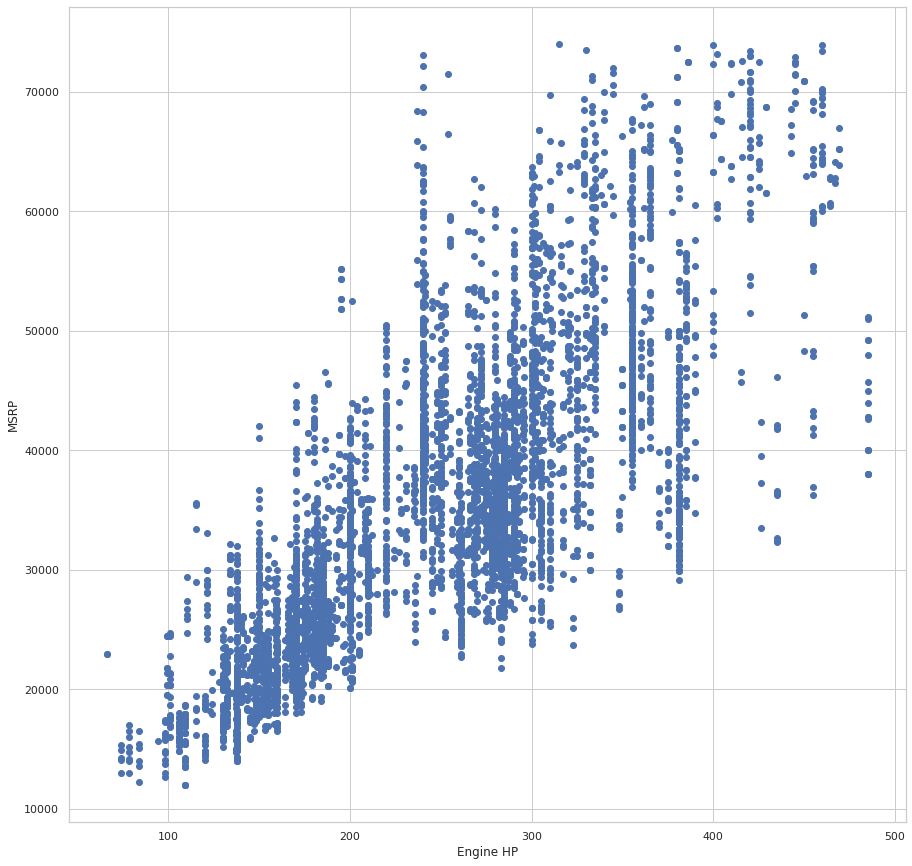

In [ ]:
plt.figure(figsize=(15,15))
plt.scatter(x,y) # Grafiquemos como se ven nuestros datos.
plt.ylabel('MSRP')
plt.xlabel("Engine HP")
plt.show()

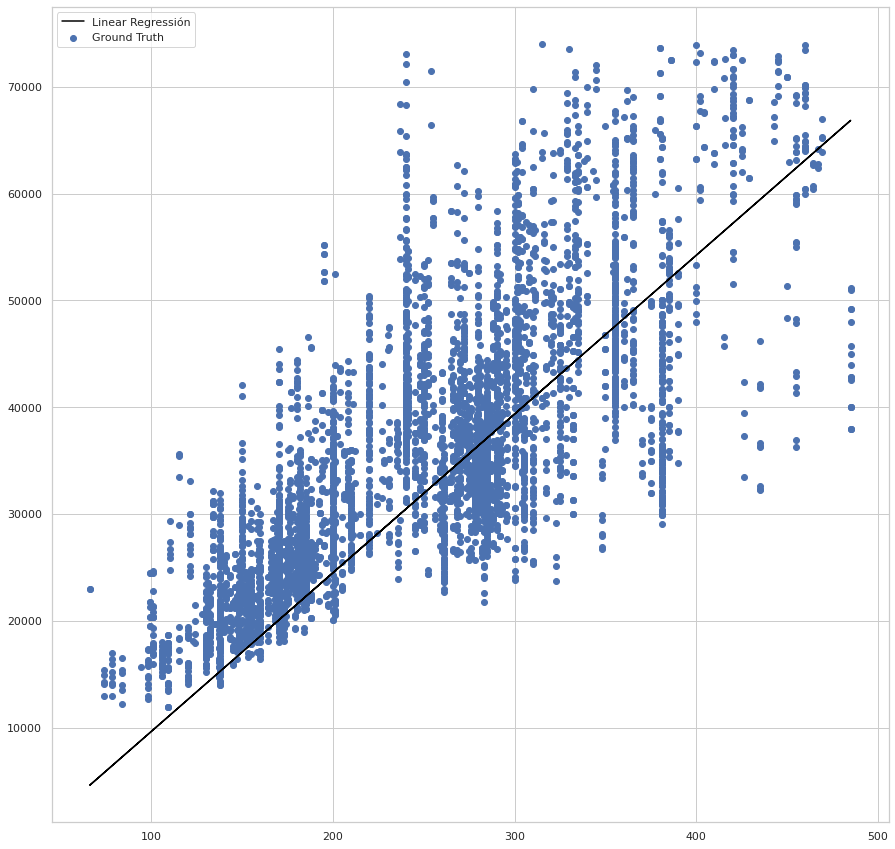

In [ ]:
plt.figure(figsize=(15,15))
plt.scatter(x,y,label="Ground Truth") # Vamos a gráficar nuestros datos originales 
plt.plot(x,lin_reg(x), color="black", label="Linear Regressión") #Luego graficamos la curva ajustada 

plt.legend()
plt.show()

In [ ]:
SST = np.sum((y - np.mean(y))**2)
SSE = np.sum((y - lin_reg(x))**2)

R2 = 1 - (SSE/SST) 
print(R2) 

Engine HP    NaN
MSRP         1.0
dtype: float64


<font color= 'orange'> **Observaciones:** </font>No logramos obtener R2, ya que este aparece como NaN, por lo que intentaremos sacarlo con otro metodo, el cual veremos a continuación:

In [ ]:
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# División de los datos en train y test
X = automoviles2[['Engine HP']]
y = automoviles2[['MSRP']]

X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y.values.reshape(-1,1),
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

In [ ]:
# Creación del modelo utilizando matrices como en scikitlearn
X_train = sm.add_constant(X_train, prepend=True)
modelo = sm.OLS(endog=y_train, exog=X_train,)
modelo = modelo.fit()
print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.588
Model:                            OLS   Adj. R-squared:                  0.588
Method:                 Least Squares   F-statistic:                     6085.
Date:                Sat, 24 Apr 2021   Prob (F-statistic):               0.00
Time:                        03:25:23   Log-Likelihood:                -44491.
No. Observations:                4269   AIC:                         8.899e+04
Df Residuals:                    4267   BIC:                         8.900e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6120.6433    400.885     15.268      0.0

<font color= 'orange'> **Observaciones:** </font>Obtenemos un R2 de 58.8%, por lo cual logramos mejorar el modelo anterior en casi 6%

<font color= 'orange'> **Elección de la segunda variable independiente:** </font>Tomaremos la segunda variable independiente (Engine Cylinders), la cual tiene 0,5 de correlacion con MSRP:

In [ ]:
automoviles3 = automoviles[['MSRP', 'Engine Cylinders']]
MSRP3 = automoviles3[['MSRP']]
automoviles3.where((MSRP3 > limitesMsrp[0]) & (MSRP3 < limitesMsrp[1]),inplace=True)
automoviles3 = automoviles3.dropna()
automoviles3

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:9011: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cond, other, inplace, axis, level, errors=errors, try_cast=try_cast


,MSRP,Engine Cylinders
0,46135.0,6.0
1,40650.0,6.0
2,36350.0,6.0
3,29450.0,6.0
4,34500.0,6.0
...,...,...
11909,46120.0,6.0
11910,56670.0,6.0
11911,50620.0,6.0
11912,50920.0,6.0


In [ ]:
x = automoviles3[['Engine Cylinders']]
y = automoviles3[['MSRP']]

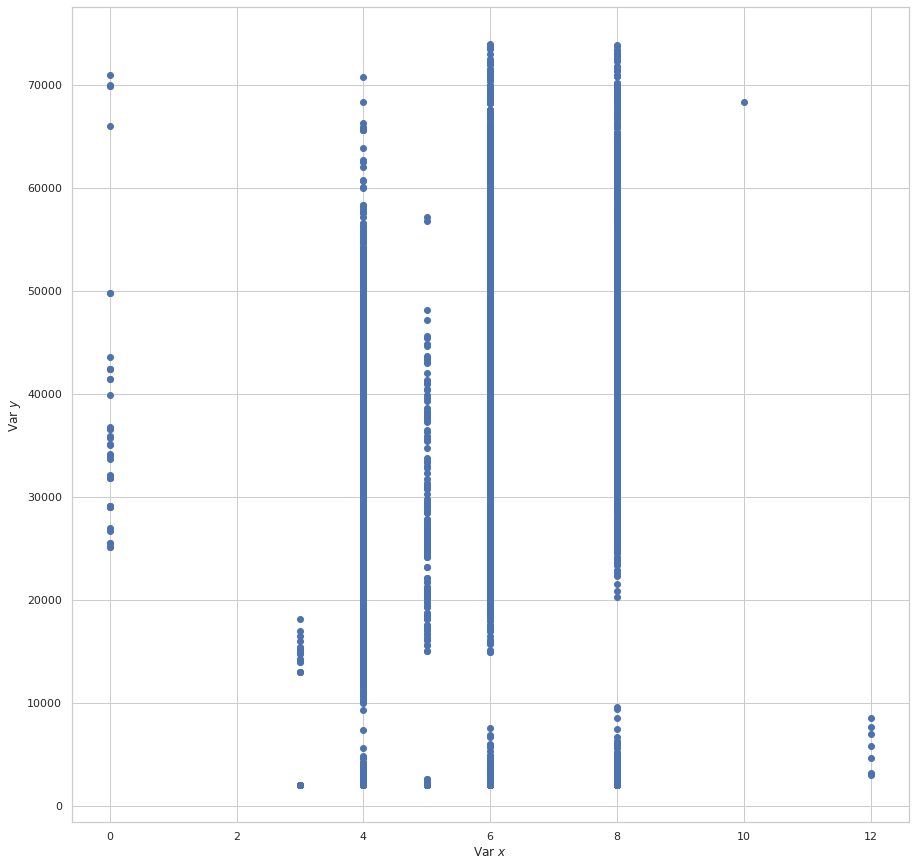

In [ ]:
plt.figure(figsize=(15,15))
plt.scatter(x,y) # Grafiquemos como se ven nuestros datos.
plt.xlabel("Var $x$")
plt.ylabel("Var $y$")
plt.show()

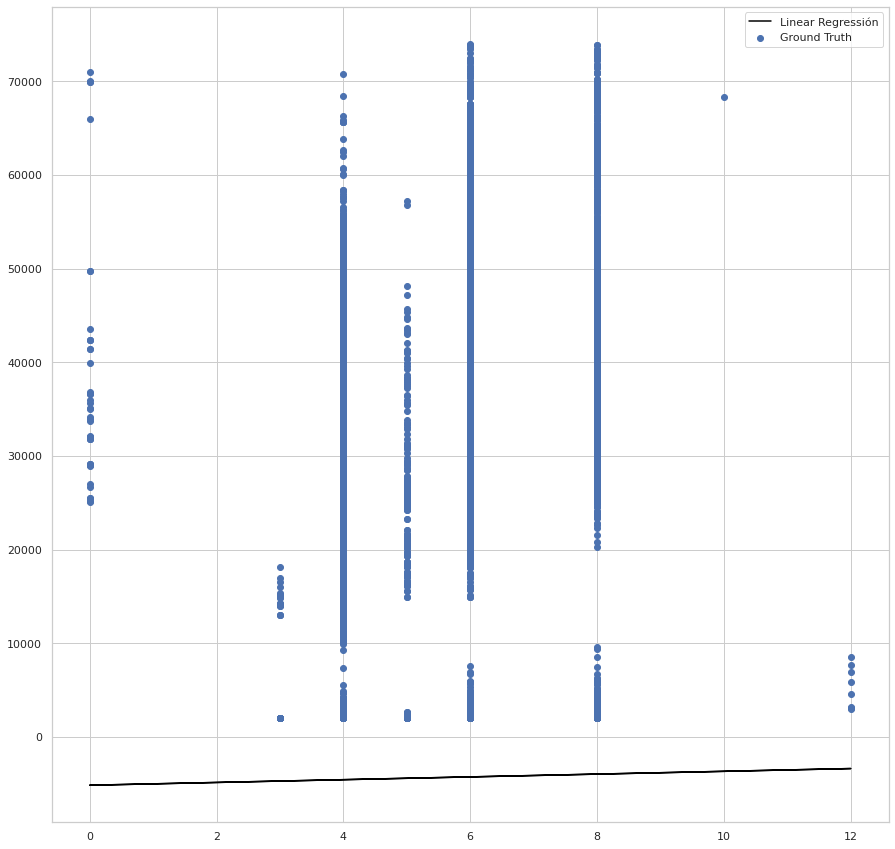

In [ ]:
plt.figure(figsize=(15,15))
plt.scatter(x,y,label="Ground Truth") # Vamos a gráficar nuestros datos originales 
plt.plot(x,lin_reg(x), color="black", label="Linear Regressión") #Luego graficamos la curva ajustada 

plt.legend()
plt.show()

In [ ]:
SST = np.sum((y - np.mean(y))**2)
SSE = np.sum((y - lin_reg(x))**2)

R2 = 1 - (SSE/SST) 
print(R2) 

Engine Cylinders    NaN
MSRP                1.0
dtype: float64


<font color= 'orange'> **Observaciones:** </font>No logramos obtener R2, ya que este aparece como NaN, por lo que intentaremos sacarlo con otro metodo, el cual veremos a continuación:

In [ ]:
# División de los datos en train y test
X = automoviles3[['Engine Cylinders']]
y = automoviles3[['MSRP']]

X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y.values.reshape(-1,1),
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

In [ ]:
# Creación del modelo utilizando matrices como en scikitlearn
X_train = sm.add_constant(X_train, prepend=True)
modelo = sm.OLS(endog=y_train, exog=X_train,)
modelo = modelo.fit()
print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.086
Method:                 Least Squares   F-statistic:                     823.2
Date:                Sat, 24 Apr 2021   Prob (F-statistic):          4.55e-173
Time:                        03:25:45   Log-Likelihood:                -96265.
No. Observations:                8710   AIC:                         1.925e+05
Df Residuals:                    8708   BIC:                         1.925e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             1.129e+04    626.717  

<font color= 'orange'> **Observaciones:** </font>Obtenemos un R2 de tan solo 0,086, lo cual indica que la variable independiente no explica la variable dependiente. En general podemos decir que las variables independientes no tienen un comportamiento lineal y dificilmente puedan por si solo generar un buen modelo lineal simple, para poder explicar la variable independiente.

#### REGRESIÓN MULTIVARIADA

Comenzamos por limpiar los datos que utilizaremos para la generación del modelo, sacando outliers, nulos y dejando la homologando la cantidad de filas de cada columna

In [ ]:
from sklearn.linear_model import LinearRegression #En este caso, de scikit-learn, de los modelos lineales, importamos la regresión lineal
lr = LinearRegression() # Y generamos un obtejo de LinearRegressión

In [ ]:
automoviles4 = automoviles[['Year', 'Engine HP', 'Engine Cylinders', 'Number of Doors', 'highway MPG', 'city mpg', 'Popularity', 'Market Category', 'MSRP']].dropna()   #se elimnaron todas las filas con al menos un dato invalido
MSRP4 = automoviles4[['MSRP']]
engine4 = automoviles4[['Engine HP']]
Highway4 = automoviles4[['highway MPG']]
City4 = automoviles4[['city mpg']]
Pop4 = automoviles4[['Popularity']]
automoviles4.where((engine4 > limitesEnginehp[0]) & (engine4 < limitesEnginehp[1]),inplace=True)
automoviles4.where((MSRP4 > limitesMsrp[0]) & (MSRP4 < limitesMsrp[1]),inplace=True)
automoviles4.where((Highway4 > limitesHighway[0]) & (Highway4 < limitesHighway[1]),inplace=True)
automoviles4.where((City4 > limitesCity[0]) & (City4 < limitesCity[1]),inplace=True)
automoviles4.where((Pop4 > limitesPopularity[0]) & (Pop4 < limitesPopularity[1]),inplace=True)

automoviles4 = automoviles4.dropna()
automoviles4

,Year,Engine HP,Engine Cylinders,Number of Doors,highway MPG,city mpg,Popularity,Market Category,MSRP
0,2011,335.0,6.0,2.0,26.0,19.0,3916.0,"Factory Tuner,Luxury,High-Performance",46135.0
1,2011,300.0,6.0,2.0,28.0,19.0,3916.0,"Luxury,Performance",40650.0
2,2011,300.0,6.0,2.0,28.0,20.0,3916.0,"Luxury,High-Performance",36350.0
3,2011,230.0,6.0,2.0,28.0,18.0,3916.0,"Luxury,Performance",29450.0
4,2011,230.0,6.0,2.0,28.0,18.0,3916.0,Luxury,34500.0
...,...,...,...,...,...,...,...,...,...
11909,2012,300.0,6.0,4.0,23.0,16.0,204.0,"Crossover,Hatchback,Luxury",46120.0
11910,2012,300.0,6.0,4.0,23.0,16.0,204.0,"Crossover,Hatchback,Luxury",56670.0
11911,2012,300.0,6.0,4.0,23.0,16.0,204.0,"Crossover,Hatchback,Luxury",50620.0
11912,2013,300.0,6.0,4.0,23.0,16.0,204.0,"Crossover,Hatchback,Luxury",50920.0


Generamos un modelo con Scikitlearn el cual nos permitira revisar facilmente cual es el R2 del modelo, incluyendo todas las variables elegidas. 

In [ ]:
# División de los datos en train y test
# ==============================================================================
X1 = automoviles4[['Year']]
X2 = automoviles4[['Engine HP']]
X3 = automoviles4[['Engine Cylinders']]
X4 = automoviles4[['Number of Doors']]
X5 = automoviles4[['highway MPG']]
X6 = automoviles4[['city mpg']]
X7 = automoviles4['Popularity']  
#X8 = automoviles4[["Market Category"]]

X = automoviles4[['Year', 'Engine HP', 'Engine Cylinders', 'Number of Doors', 'highway MPG', 'city mpg', 'Popularity']]

y = automoviles4[['MSRP']]  

X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y.values.reshape(-1,1),
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

In [ ]:
# Creación del modelo utilizando matrices como en scikitlearn
X_train = sm.add_constant(X_train, prepend=True)
modelo = sm.OLS(endog=y_train, exog=X_train,)
modelo = modelo.fit()
print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.688
Model:                            OLS   Adj. R-squared:                  0.687
Method:                 Least Squares   F-statistic:                     1573.
Date:                Sat, 24 Apr 2021   Prob (F-statistic):               0.00
Time:                        03:36:42   Log-Likelihood:                -52496.
No. Observations:                5002   AIC:                         1.050e+05
Df Residuals:                    4994   BIC:                         1.051e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -1.921e+06   5.15e+04  

<font color= 'orange'> **Observaciones:** </font>Nuestro modelo tiene un R2 de 68,8% y veremos si podemos mejorarlo, a traves de la elimnacion de variables segun los P-Value, dejando fuera variables con valores sobre 0,05, lo cual en teoria nos deberia permitir tener un modelo mas exacto

In [ ]:
X = automoviles4[['Year', 'Engine HP', 'Number of Doors']]

y = automoviles4[['MSRP']]  

X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y.values.reshape(-1,1),
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

In [ ]:
# Creación del modelo utilizando matrices como en scikitlearn
# ==============================================================================
# A la matriz de predictores se le tiene que añadir una columna de 1s para el intercept del modelo
X_train = sm.add_constant(X_train, prepend=True)
modelo = sm.OLS(endog=y_train, exog=X_train,)
modelo = modelo.fit()
print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.686
Model:                            OLS   Adj. R-squared:                  0.686
Method:                 Least Squares   F-statistic:                     3645.
Date:                Sat, 24 Apr 2021   Prob (F-statistic):               0.00
Time:                        03:36:48   Log-Likelihood:                -52509.
No. Observations:                5002   AIC:                         1.050e+05
Df Residuals:                    4998   BIC:                         1.051e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -2.083e+06   3.99e+04    -

<font color= 'orange'> **Observaciones:** </font>EL R2 del modelo queda muy similar llegando al 68.6%, por lo que generaremos la regresión con el modelo anterior, el cual tiene un R2 del 68.8%

In [ ]:
X1 = automoviles4['Year']
X2 = automoviles4['Engine HP']
X3 = automoviles4['Engine Cylinders']
X4 = automoviles4['Number of Doors']
X5 = automoviles4['highway MPG']
X6 = automoviles4['city mpg']
X7 = automoviles4['Popularity'] 
#X8 = automoviles4[["Market Category"]]

X_ = automoviles4[['Year', 'Engine HP', 'Engine Cylinders', 'Number of Doors', 'highway MPG', 'city mpg', 'Popularity']]

y = automoviles4['MSRP']

In [ ]:
lr.fit(X_,y.values)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
lr.intercept_, lr.coef_

(-1913076.2228318662,
 array([ 9.50136509e+02,  1.28236671e+02, -3.48867553e+02,  6.66558652e+02,
         9.60753185e+01,  1.72810507e+01,  1.38390656e-01]))

In [ ]:
beta_1 = lr.coef_[0]
beta_2 = lr.coef_[1]
beta_3 = lr.coef_[2]
beta_4 = lr.coef_[3]
beta_5 = lr.coef_[4]
beta_6 = lr.coef_[5]
beta_7 = lr.coef_[6]
beta_0 = lr.intercept_

beta_0

-1913076.2228318662

In [ ]:
def lin_reg4(X1,X2,X3,X4,X5,X6,X7):
    y_hat = (beta_1 * X1) + (beta_2 * X2) + (beta_3 * X3) + (beta_4 * X4) + (beta_5 * X5) + (beta_6 * X6) + (beta_7 * X7) + beta_0
    return y_hat

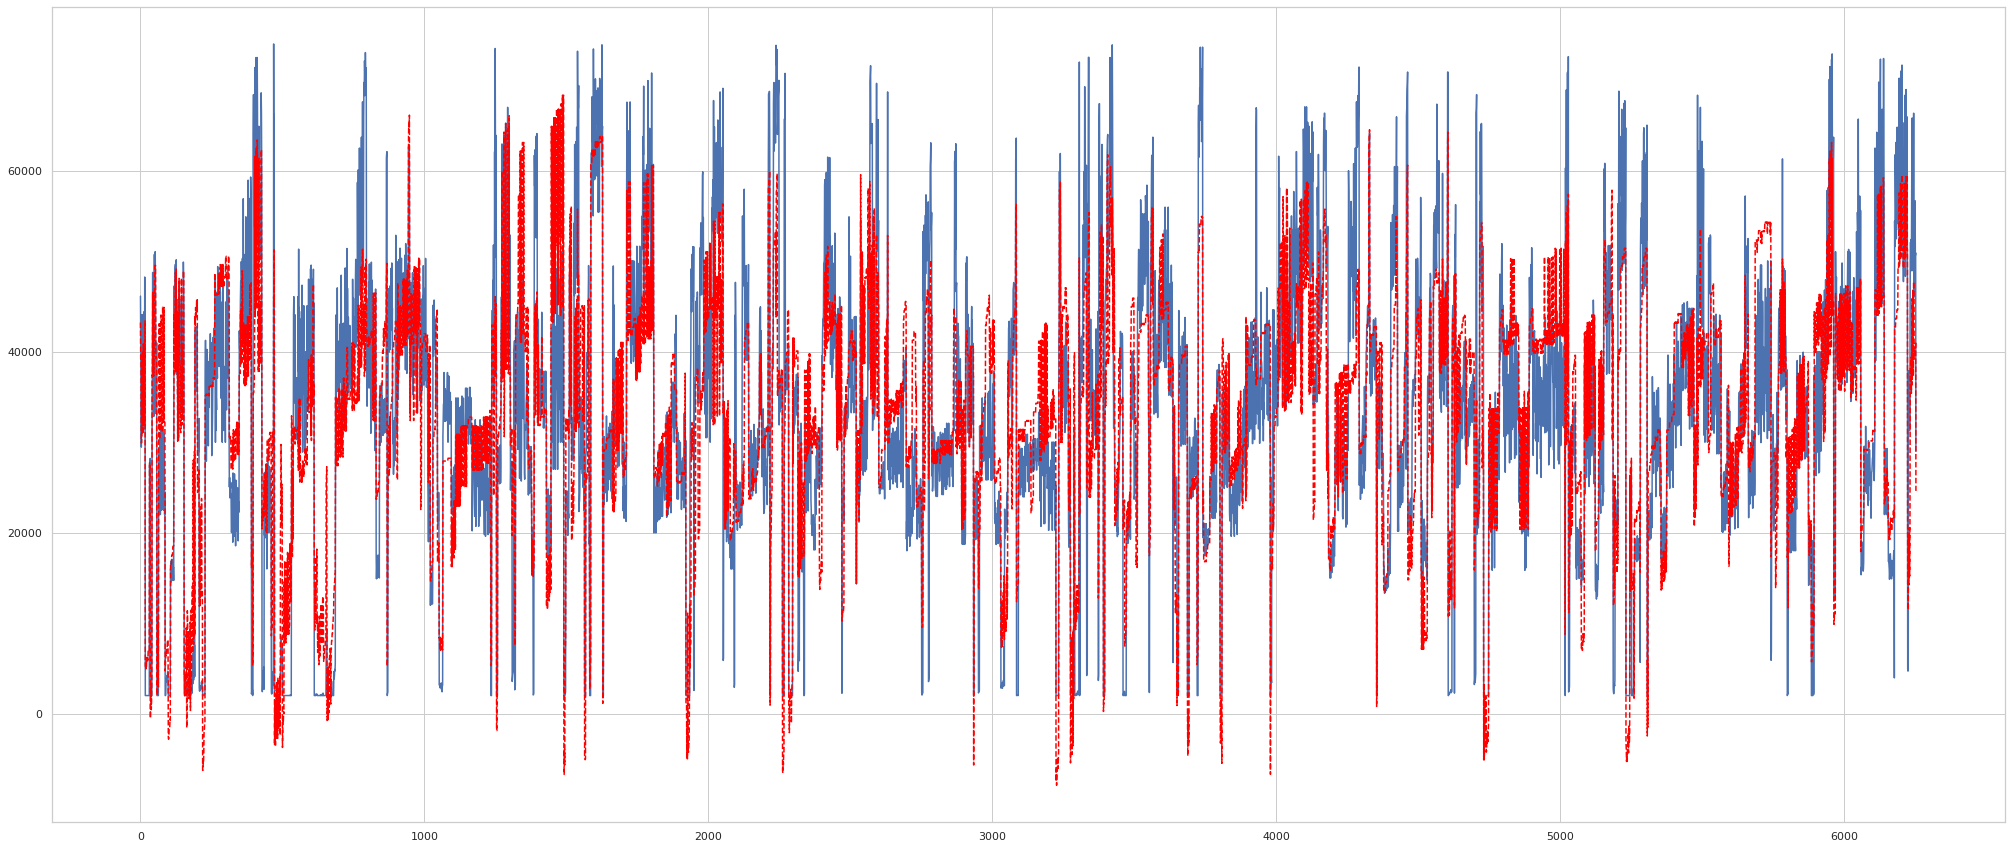

In [ ]:
plt.figure(figsize=(35,15))
plt.plot(np.arange(len(y)),y,label="Original")
plt.plot(np.arange(len(y)),lin_reg4(X1,X2,X3,X4,X5,X6,X7),'--',color="red", label="Generados")

plt.show()

<font color= 'orange'> **Observaciones:** </font>Tenemos problemas con generar el modelo con tanta data, por lo que obtaremos por hacer el modelo con las variables que mejor explican la variable independiente

In [ ]:
X_1 = automoviles4[['Year', 'Engine HP', 'Number of Doors']]

y = automoviles4['MSRP']

In [ ]:
lr.fit(X_1,y.values)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
lr.intercept_, lr.coef_

(-2062052.2110364665, array([1026.25882375,  118.13740314,  532.46431741]))

In [ ]:
beta_1 = lr.coef_[0]
beta_2 = lr.coef_[1]
beta_3 = lr.coef_[2]
beta_0 = lr.intercept_

In [ ]:
def lin_reg5(X1,X2,X3):
    y_hat = (beta_1 * X1) + (beta_2 * X2) + (beta_3 * X3) + beta_0
    return y_hat

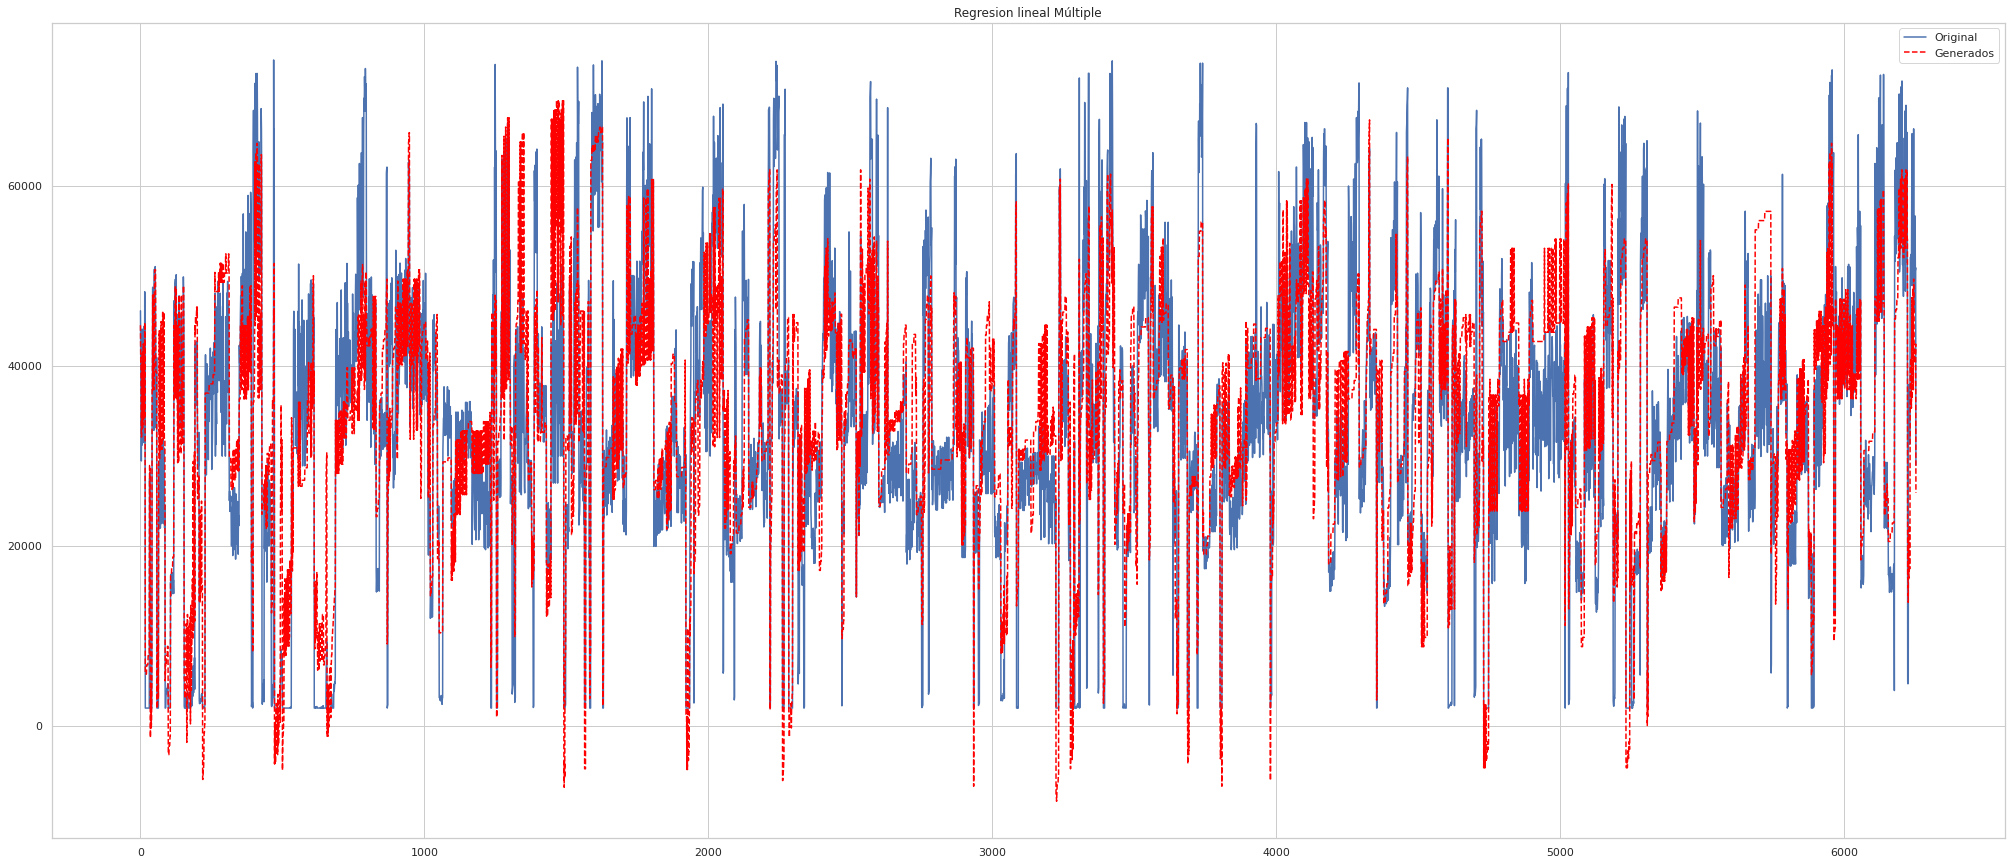

In [ ]:
plt.figure(figsize=(35,15))
plt.plot(np.arange(len(y)),y,label="Original")
plt.plot(np.arange(len(y)),lin_reg5(X1,X2,X3),'--',color="red", label="Generados")

plt.legend()
plt.title('Regresion lineal Múltiple')
plt.show()

In [ ]:
SST = np.sum((y - np.mean(y))**2)
SSE = np.sum((y - lin_reg5(X1,X2,X3))**2)

R2 = 1 - (SSE/SST) 
print(R2)

0.6789433399496926


In [ ]:
mse = np.sum((y - lin_reg5(X1,X2,X3))**2) / len(y)   #MSE indica que tan bueno es nuestro modelo con respecto a los valores atipicos.
mae = np.sum(np.abs(y - lin_reg5(X1,X2,X3))) / len(y)   #MAE magnitud del promedio de los residuos, da vision general de como podria comportarse la regresion.
mape = np.sum(np.abs((y - lin_reg5(X1,X2,X3))/y)) / len(y)    #MAPE indica porcentualmente que tanto se alejan nuestros valores predichos de los reales.

In [ ]:
print(f'MSE:{mse} \nMAE: {mae} \nMAPE: {mape}')

MSE:78595813.12873553 
MAE: 6870.007149896827 
MAPE: 0.4988766394583127


Modelo tiene un MAPE de casi 50% lo cual no lo hace muy fiable y tiene 50% en promedio de posibilidad de errar

<font color= 'orange'> **Observaciones:** </font>Nuestro modelo finalmente tiene un R2 de alrededor de 67.8%, lo cual es bastante similar al modelos que contiene todas las variables, el cual llega a un R2 68%

#### <font color= 'orange'> **CONCLUSIONES DEL PROYECTO** </font> 
SE PUDO TENER UN MEJOR ENTENDIMIENTO DE LA DATA A TRAVÉS DE UN ANALISIS EXPLORATORIO, EN DONDE SE LEVANTARÁN LAS PRINCIPALES OPORTUNIDADES DE PODER ESTABLECER LOS PRIMEROS INDICIOS DE UN MODELO DE PREDICCIÓN



*   Con respecto al analisis YEAR, la variable no demuestra un comportamiento homogeneo que permita presuponer algun tipo de tendencia, ya que ha tenido un crecimiento excesivamente elevado en los ultimos años y puede significar un valor sobrestimado.
*   La variable del Análisis Engine HP, no posee un comportamiento estacional, sino mas bien, un comportamiento caotico.A pesar de ello, esta relacionada con la cantidad de cilindros del motor, esto presupone la oportunidad de modelar algun tipo de modelo lineal, sin embargo como oportnidad de mercado, puediera no ser de interés corporativo.
* Para el análisis del número de puertas, gran parte de las observaciones son de 4 puertas y en segundo lugar 2, pero no representan una oportunidad de modelamiento ni predicción, ya que no hay correlación de esta con más variables.
* En el analisis bi variariado los rendimiento en ciudad y en carretera tienen alta relació, sin embargo es una propiedad compartida que no aportaría en mayor medida a un modelamiento.
* En general, el analisis univariado nos ha repsentado una visualización a grandes razgos del comportamiento de las variables para la data analizada. En el analisis bivariado se logró enriquecer en mejor medida el análisis.

CON RESPECTO A LAS REGRESIONES LINEALES, SE ENCONTRÓ QUE EXISTEN 2 GRANDES ESCENARIOS. EN PRIMER LUGAR VEMOS QUE EL MODELO DE REGRESIÓN LINEAL SIMPLE NO TIENE UN BUEN DESEMPEÑO. SOLO SE APROBARÍA LA IDEA DE MODELAR CON UN R2 SUPERIOR AL 90%. A SU VEZ, SE PROBÓ UN MODELO MULTIVARIADO PERO NO SE CONSIGUIERON RESULTADOS DE ALTA CALIDAD. ES POSIBLE QUE SEA NECESARIO BUSCAR OTRAS ALTERNATIVAS DE MODELAMIENTO, PERO EN ESTE CASO UN MODELO LINEAL NO ES UN BUEN CAMINO PARA UN MODELO PREDICTIVO.